In [1]:
import tensorflow as tf
import pickle
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import zipfile
import shutil
import os

from functions import split_data
from models import deepcfd

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
# Downloading origianl implementation and data
!wget --no-check-certificate \
    "https://zenodo.org/record/3666056/files/DeepCFD.zip?download=1" \
    -O "/fsx/python_ml/DeepCFD-TF/DeepCFD.zip"

--2021-02-10 22:47:39--  https://zenodo.org/record/3666056/files/DeepCFD.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179267182 (171M) [application/octet-stream]
Saving to: ‘/fsx/python_ml/DeepCFD-TF/DeepCFD.zip’

100%[======================================>] 179,267,182 48.9MB/s   in 3.7s   

2021-02-10 22:47:43 (46.8 MB/s) - ‘/fsx/python_ml/DeepCFD-TF/DeepCFD.zip’ saved [179267182/179267182]



In [2]:
# Processing the downloaded zip
deepcfd_zip_path = os.path.join(os.getcwd(), 'DeepCFD.zip')
deepcfd_unzip_path = os.path.join(os.getcwd(), 'DeepCFD')
try:
    os.mkdir(deepcfd_unzip_path)
    shutil.rmtree(deepcfd_unzip_path)
    zip_ref = zipfile.ZipFile(deepcfd_zip_path, 'r')
    zip_ref.extractall(deepcfd_unzip_path)
    zip_ref.close()
except OSError:
    pass

In [3]:
print('The contents of the zipfile inlcude:\n-    {}'.format('\n-    '.join(os.listdir('DeepCFD'))))

The contents of the zipfile inlcude:
-    dataX.pkl
-    Run
-    pytorchtools.py
-    __init__.py
-    dataY.pkl
-    train_functions.py
-    DeepCFD.py
-    functions.py
-    Models
-    __pycache__


In [4]:
# Setting up device and loading training data
device_name = '/gpu:0' if tf.config.list_physical_devices('GPU') is not None else '/cpu:0'
device = tf.device(device_name)

x_path = os.path.join(os.getcwd(), 'DeepCFD', 'dataX.pkl')
y_path = os.path.join(os.getcwd(), 'DeepCFD', 'dataY.pkl')
x = pickle.load(open(x_path, 'rb'))
y = pickle.load(open(y_path, 'rb'))

print(f'Using device {device_name}')
print(f'X input has shape of :{x.shape}')
print(f'Y input has shape of :{y.shape}')

# reshaping x and y to the format
# (m_examples, height, width, depth)
x = np.transpose(x[:,:,:,:], axes=(0,3,2,1))
y = np.transpose(y[:,:,:,:], axes=(0,3,2,1))
print(f'Reshaped X input has shape of :{x.shape}')
print(f'Reshaped Y input has shape of :{y.shape}')

Using device /gpu:0
X input has shape of :(981, 3, 172, 79)
Y input has shape of :(981, 3, 172, 79)
Reshaped X input has shape of :(981, 79, 172, 3)
Reshaped Y input has shape of :(981, 79, 172, 3)


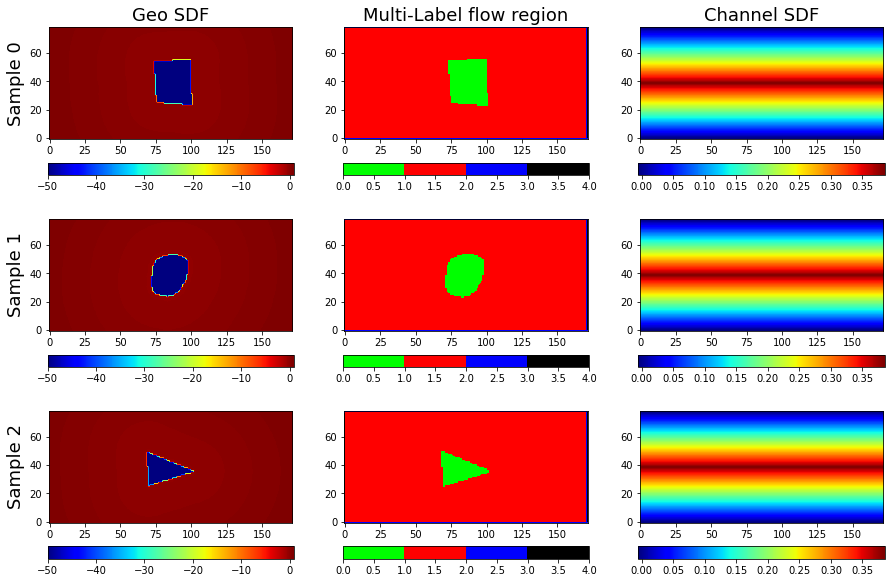

In [5]:
# visualising data
samples = range(3)
colours = [(0, 1, 0), (1, 0, 0), (0, 0, 1), (0, 0, 0)]
cmap = LinearSegmentedColormap.from_list('custom_map', colours, N=4)

fig, axs = plt.subplots(3, 3, figsize=(15,10))
for idx, sample in enumerate(samples):
    vmin = np.min(x[idx,:,:,0])
    vmax = np.max(x[idx,:,:,0])
    im = axs[idx, 0].imshow(x[idx,:,:,0], cmap='jet', vmin = vmin, vmax = vmax, origin='lower')
    fig.colorbar(im, orientation='horizontal', ax=axs[idx,0])

    vmin = np.min(x[idx,:,:,1])
    vmax = np.max(x[idx,:,:,1])
    im = axs[idx,1].imshow(x[idx,:,:,1], cmap=cmap, vmin = vmin, vmax = vmax, origin='lower')
    fig.colorbar(im, orientation='horizontal', ax=axs[idx,1])

    vmin = np.min(x[idx,:,:,2])
    vmax = np.max(x[idx,:,:,2])
    im = axs[idx,2].imshow(x[idx,:,:,2], cmap='jet', vmin = vmin, vmax = vmax, origin='lower')
    fig.colorbar(im, orientation='horizontal', ax=axs[idx,2])

axs[0,0].set_title('Geo SDF', fontsize=18)
axs[0,1].set_title('Multi-Label flow region', fontsize=18)
axs[0,2].set_title('Channel SDF', fontsize=18)

axs[0,0].set_ylabel(f'Sample {samples[0]}', fontsize=18)
axs[1,0].set_ylabel(f'Sample {samples[1]}', fontsize=18)
axs[2,0].set_ylabel(f'Sample {samples[2]}', fontsize=18)

fig.show()

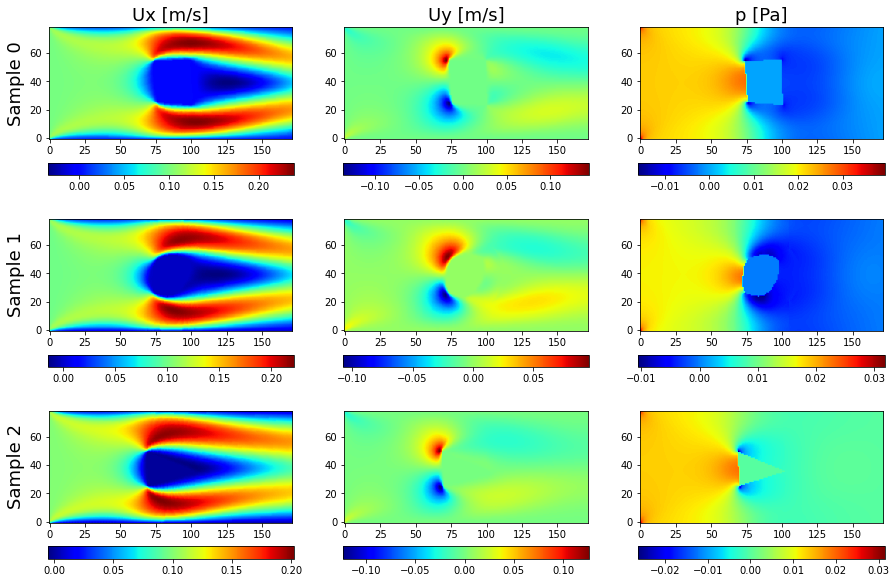

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
for idx, sample in enumerate(samples):
    vmin = np.min(y[idx,:,:,0])
    vmax = np.max(y[idx,:,:,0])
    im = axs[idx, 0].imshow(y[idx,:,:,0], cmap='jet', vmin = vmin, vmax = vmax, origin='lower')
    fig.colorbar(im, orientation='horizontal', ax=axs[idx,0])

    vmin = np.min(y[idx,:,:,1])
    vmax = np.max(y[idx,:,:,1])
    im = axs[idx,1].imshow(y[idx,:,:,1], cmap='jet', vmin = vmin, vmax = vmax, origin='lower')
    fig.colorbar(im, orientation='horizontal', ax=axs[idx,1])

    vmin = np.min(y[idx,:,:,2])
    vmax = np.max(y[idx,:,:,2])
    im = axs[idx,2].imshow(y[idx,:,:,2], cmap='jet', vmin = vmin, vmax = vmax, origin='lower')
    fig.colorbar(im, orientation='horizontal', ax=axs[idx,2])

axs[0,0].set_title('Ux [m/s]', fontsize=18)
axs[0,1].set_title('Uy [m/s]', fontsize=18)
axs[0,2].set_title('p [Pa]', fontsize=18)

axs[0,0].set_ylabel(f'Sample {samples[0]}', fontsize=18)
axs[1,0].set_ylabel(f'Sample {samples[1]}', fontsize=18)
axs[2,0].set_ylabel(f'Sample {samples[2]}', fontsize=18)

fig.show()

In [7]:
# Splitting the data into train and test sets
train_data_x, train_data_y, test_data_x, test_data_y = split_data(x, y, ratio=0.7)

print(f'The shape of the training x data is {train_data_x.shape}')
print(f'The shape of the training y data is {train_data_y.shape}')
print(f'The shape of the testing x data is {test_data_x.shape}')
print(f'The shape of the testing y data is {test_data_y.shape}')

The shape of the training x data is (686, 79, 172, 3)
The shape of the training y data is (686, 79, 172, 3)
The shape of the testing x data is (295, 79, 172, 3)
The shape of the testing y data is (295, 79, 172, 3)


In [8]:
# Tensorflow model
%autoreload 2
from models import deepcfd

input_height = x.shape[1]
input_width = x.shape[2]
input_channels = x.shape[3]

weight_decay = 0.005
learning_rate = 0.001

model = deepcfd(input_height, input_width, input_channels, weight_decay, learning_rate)
model.summary()

Model: "DeepCFD"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 79, 172, 3)] 0                                            
__________________________________________________________________________________________________
block1_layer1_conv2d (Conv2D)   (None, 79, 172, 8)   608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 172, 8)   1608        block1_layer1_conv2d[0][0]       
__________________________________________________________________________________________________
max_pooling_with_argmax2d (MaxP [(None, 39, 86, 8),  0           conv2d[0][0]                     
____________________________________________________________________________________________

In [10]:
# Removing previous logs
! rm -rf ./logs/

# Define the Keras TensorBoard callback.
from datetime import datetime
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

y_split = {
    'ux': y[:,:,:,0],
    'uy': y[:,:,:,1],
    'p': y[:,:,:,2]
}

history = model.fit(
    x = x,
    y = y_split,
    validation_split = 0.7,
    epochs=500,
    callbacks=[tensorboard_callback],
    verbose=2
)

Epoch 1/500
10/10 - 2s - loss: 0.0974 - ux_loss: 0.0319 - uy_loss: 0.0148 - p_loss: 0.0507 - ux_acc: 0.0307 - ux_mse: 0.0319 - uy_acc: 0.0310 - uy_mse: 0.0148 - p_acc: 0.0270 - p_mae: 0.0507 - val_loss: 0.0571 - val_ux_loss: 0.0196 - val_uy_loss: 0.0060 - val_p_loss: 0.0315 - val_ux_acc: 0.0319 - val_ux_mse: 0.0196 - val_uy_acc: 0.0348 - val_uy_mse: 0.0060 - val_p_acc: 0.0320 - val_p_mae: 0.0315
Epoch 2/500
10/10 - 1s - loss: 0.0464 - ux_loss: 0.0162 - uy_loss: 0.0041 - p_loss: 0.0261 - ux_acc: 0.0339 - ux_mse: 0.0162 - uy_acc: 0.0360 - uy_mse: 0.0041 - p_acc: 0.0342 - p_mae: 0.0261 - val_loss: 0.0350 - val_ux_loss: 0.0128 - val_uy_loss: 0.0024 - val_p_loss: 0.0199 - val_ux_acc: 0.0346 - val_ux_mse: 0.0128 - val_uy_acc: 0.0355 - val_uy_mse: 0.0024 - val_p_acc: 0.0349 - val_p_mae: 0.0199
Epoch 3/500
10/10 - 1s - loss: 0.0309 - ux_loss: 0.0114 - uy_loss: 0.0018 - p_loss: 0.0177 - ux_acc: 0.0358 - ux_mse: 0.0114 - uy_acc: 0.0363 - uy_mse: 0.0018 - p_acc: 0.0361 - p_mae: 0.0177 - val_loss:

Epoch 21/500
10/10 - 1s - loss: 0.0118 - ux_loss: 0.0035 - uy_loss: 2.9993e-04 - p_loss: 0.0080 - ux_acc: 0.0363 - ux_mse: 0.0035 - uy_acc: 0.0363 - uy_mse: 2.9993e-04 - p_acc: 0.0363 - p_mae: 0.0080 - val_loss: 0.0117 - val_ux_loss: 0.0035 - val_uy_loss: 3.0609e-04 - val_p_loss: 0.0079 - val_ux_acc: 0.0356 - val_ux_mse: 0.0035 - val_uy_acc: 0.0356 - val_uy_mse: 3.0609e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0079
Epoch 22/500
10/10 - 1s - loss: 0.0118 - ux_loss: 0.0035 - uy_loss: 2.9998e-04 - p_loss: 0.0080 - ux_acc: 0.0363 - ux_mse: 0.0035 - uy_acc: 0.0363 - uy_mse: 2.9998e-04 - p_acc: 0.0363 - p_mae: 0.0080 - val_loss: 0.0118 - val_ux_loss: 0.0035 - val_uy_loss: 3.0614e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 0.0035 - val_uy_acc: 0.0356 - val_uy_mse: 3.0614e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 23/500
10/10 - 1s - loss: 0.0118 - ux_loss: 0.0035 - uy_loss: 3.0004e-04 - p_loss: 0.0080 - ux_acc: 0.0363 - ux_mse: 0.0035 - uy_acc: 0.0363 - uy_mse: 3.0004e-04 

Epoch 41/500
10/10 - 1s - loss: 0.0116 - ux_loss: 0.0033 - uy_loss: 3.0052e-04 - p_loss: 0.0080 - ux_acc: 0.0363 - ux_mse: 0.0033 - uy_acc: 0.0363 - uy_mse: 3.0052e-04 - p_acc: 0.0363 - p_mae: 0.0080 - val_loss: 0.0114 - val_ux_loss: 0.0033 - val_uy_loss: 3.0665e-04 - val_p_loss: 0.0078 - val_ux_acc: 0.0356 - val_ux_mse: 0.0033 - val_uy_acc: 0.0356 - val_uy_mse: 3.0665e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0078
Epoch 42/500
10/10 - 1s - loss: 0.0116 - ux_loss: 0.0033 - uy_loss: 3.0053e-04 - p_loss: 0.0080 - ux_acc: 0.0363 - ux_mse: 0.0033 - uy_acc: 0.0363 - uy_mse: 3.0053e-04 - p_acc: 0.0363 - p_mae: 0.0080 - val_loss: 0.0114 - val_ux_loss: 0.0033 - val_uy_loss: 3.0665e-04 - val_p_loss: 0.0078 - val_ux_acc: 0.0356 - val_ux_mse: 0.0033 - val_uy_acc: 0.0356 - val_uy_mse: 3.0665e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0078
Epoch 43/500
10/10 - 1s - loss: 0.0116 - ux_loss: 0.0033 - uy_loss: 3.0053e-04 - p_loss: 0.0079 - ux_acc: 0.0363 - ux_mse: 0.0033 - uy_acc: 0.0363 - uy_mse: 3.0053e-04 

Epoch 61/500
10/10 - 1s - loss: 0.0115 - ux_loss: 0.0032 - uy_loss: 3.0054e-04 - p_loss: 0.0079 - ux_acc: 0.0363 - ux_mse: 0.0032 - uy_acc: 0.0363 - uy_mse: 3.0054e-04 - p_acc: 0.0363 - p_mae: 0.0079 - val_loss: 0.0114 - val_ux_loss: 0.0033 - val_uy_loss: 3.0667e-04 - val_p_loss: 0.0078 - val_ux_acc: 0.0356 - val_ux_mse: 0.0033 - val_uy_acc: 0.0356 - val_uy_mse: 3.0667e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0078
Epoch 62/500
10/10 - 1s - loss: 0.0115 - ux_loss: 0.0032 - uy_loss: 3.0055e-04 - p_loss: 0.0079 - ux_acc: 0.0363 - ux_mse: 0.0032 - uy_acc: 0.0363 - uy_mse: 3.0055e-04 - p_acc: 0.0363 - p_mae: 0.0079 - val_loss: 0.0113 - val_ux_loss: 0.0033 - val_uy_loss: 3.0667e-04 - val_p_loss: 0.0078 - val_ux_acc: 0.0356 - val_ux_mse: 0.0033 - val_uy_acc: 0.0356 - val_uy_mse: 3.0667e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0078
Epoch 63/500
10/10 - 1s - loss: 0.0115 - ux_loss: 0.0032 - uy_loss: 3.0055e-04 - p_loss: 0.0079 - ux_acc: 0.0363 - ux_mse: 0.0032 - uy_acc: 0.0363 - uy_mse: 3.0055e-04 

Epoch 81/500
10/10 - 1s - loss: 0.0114 - ux_loss: 0.0032 - uy_loss: 3.0054e-04 - p_loss: 0.0079 - ux_acc: 0.0363 - ux_mse: 0.0032 - uy_acc: 0.0363 - uy_mse: 3.0054e-04 - p_acc: 0.0363 - p_mae: 0.0079 - val_loss: 0.0112 - val_ux_loss: 0.0032 - val_uy_loss: 3.0667e-04 - val_p_loss: 0.0077 - val_ux_acc: 0.0356 - val_ux_mse: 0.0032 - val_uy_acc: 0.0356 - val_uy_mse: 3.0667e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0077
Epoch 82/500
10/10 - 1s - loss: 0.0114 - ux_loss: 0.0032 - uy_loss: 3.0054e-04 - p_loss: 0.0079 - ux_acc: 0.0363 - ux_mse: 0.0032 - uy_acc: 0.0363 - uy_mse: 3.0054e-04 - p_acc: 0.0363 - p_mae: 0.0079 - val_loss: 0.0112 - val_ux_loss: 0.0032 - val_uy_loss: 3.0667e-04 - val_p_loss: 0.0077 - val_ux_acc: 0.0356 - val_ux_mse: 0.0032 - val_uy_acc: 0.0356 - val_uy_mse: 3.0667e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0077
Epoch 83/500
10/10 - 1s - loss: 0.0113 - ux_loss: 0.0032 - uy_loss: 3.0054e-04 - p_loss: 0.0078 - ux_acc: 0.0363 - ux_mse: 0.0032 - uy_acc: 0.0363 - uy_mse: 3.0054e-04 

Epoch 101/500
10/10 - 1s - loss: 0.0105 - ux_loss: 0.0028 - uy_loss: 3.0055e-04 - p_loss: 0.0075 - ux_acc: 0.0363 - ux_mse: 0.0028 - uy_acc: 0.0363 - uy_mse: 3.0055e-04 - p_acc: 0.0363 - p_mae: 0.0075 - val_loss: 0.0105 - val_ux_loss: 0.0028 - val_uy_loss: 3.0667e-04 - val_p_loss: 0.0074 - val_ux_acc: 0.0356 - val_ux_mse: 0.0028 - val_uy_acc: 0.0356 - val_uy_mse: 3.0667e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0074
Epoch 102/500
10/10 - 1s - loss: 0.0105 - ux_loss: 0.0027 - uy_loss: 3.0054e-04 - p_loss: 0.0075 - ux_acc: 0.0363 - ux_mse: 0.0027 - uy_acc: 0.0363 - uy_mse: 3.0054e-04 - p_acc: 0.0363 - p_mae: 0.0075 - val_loss: 0.0103 - val_ux_loss: 0.0027 - val_uy_loss: 3.0666e-04 - val_p_loss: 0.0073 - val_ux_acc: 0.0356 - val_ux_mse: 0.0027 - val_uy_acc: 0.0356 - val_uy_mse: 3.0666e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0073
Epoch 103/500
10/10 - 1s - loss: 0.0104 - ux_loss: 0.0027 - uy_loss: 3.0054e-04 - p_loss: 0.0074 - ux_acc: 0.0363 - ux_mse: 0.0027 - uy_acc: 0.0363 - uy_mse: 3.0054e-

Epoch 121/500
10/10 - 1s - loss: 0.0109 - ux_loss: 0.0026 - uy_loss: 3.0054e-04 - p_loss: 0.0080 - ux_acc: 0.0363 - ux_mse: 0.0026 - uy_acc: 0.0363 - uy_mse: 3.0054e-04 - p_acc: 0.0363 - p_mae: 0.0080 - val_loss: 0.0107 - val_ux_loss: 0.0026 - val_uy_loss: 3.0667e-04 - val_p_loss: 0.0078 - val_ux_acc: 0.0356 - val_ux_mse: 0.0026 - val_uy_acc: 0.0356 - val_uy_mse: 3.0667e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0078
Epoch 122/500
10/10 - 1s - loss: 0.0108 - ux_loss: 0.0025 - uy_loss: 3.0054e-04 - p_loss: 0.0079 - ux_acc: 0.0363 - ux_mse: 0.0025 - uy_acc: 0.0363 - uy_mse: 3.0054e-04 - p_acc: 0.0363 - p_mae: 0.0079 - val_loss: 0.0107 - val_ux_loss: 0.0026 - val_uy_loss: 3.0667e-04 - val_p_loss: 0.0078 - val_ux_acc: 0.0356 - val_ux_mse: 0.0026 - val_uy_acc: 0.0356 - val_uy_mse: 3.0667e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0078
Epoch 123/500
10/10 - 1s - loss: 0.0108 - ux_loss: 0.0025 - uy_loss: 3.0054e-04 - p_loss: 0.0079 - ux_acc: 0.0363 - ux_mse: 0.0025 - uy_acc: 0.0363 - uy_mse: 3.0054e-

Epoch 141/500
10/10 - 1s - loss: 0.0101 - ux_loss: 0.0022 - uy_loss: 3.0053e-04 - p_loss: 0.0076 - ux_acc: 0.0363 - ux_mse: 0.0022 - uy_acc: 0.0363 - uy_mse: 3.0053e-04 - p_acc: 0.0363 - p_mae: 0.0076 - val_loss: 0.0099 - val_ux_loss: 0.0022 - val_uy_loss: 3.0665e-04 - val_p_loss: 0.0074 - val_ux_acc: 0.0356 - val_ux_mse: 0.0022 - val_uy_acc: 0.0356 - val_uy_mse: 3.0665e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0074
Epoch 142/500
10/10 - 1s - loss: 0.0100 - ux_loss: 0.0022 - uy_loss: 3.0053e-04 - p_loss: 0.0076 - ux_acc: 0.0363 - ux_mse: 0.0022 - uy_acc: 0.0363 - uy_mse: 3.0053e-04 - p_acc: 0.0363 - p_mae: 0.0076 - val_loss: 0.0099 - val_ux_loss: 0.0021 - val_uy_loss: 3.0664e-04 - val_p_loss: 0.0074 - val_ux_acc: 0.0356 - val_ux_mse: 0.0021 - val_uy_acc: 0.0356 - val_uy_mse: 3.0664e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0074
Epoch 143/500
10/10 - 1s - loss: 0.0100 - ux_loss: 0.0021 - uy_loss: 3.0052e-04 - p_loss: 0.0076 - ux_acc: 0.0363 - ux_mse: 0.0021 - uy_acc: 0.0363 - uy_mse: 3.0052e-

Epoch 161/500
10/10 - 1s - loss: 0.0093 - ux_loss: 0.0013 - uy_loss: 2.9977e-04 - p_loss: 0.0077 - ux_acc: 0.0363 - ux_mse: 0.0013 - uy_acc: 0.0363 - uy_mse: 2.9977e-04 - p_acc: 0.0363 - p_mae: 0.0077 - val_loss: 0.0091 - val_ux_loss: 0.0013 - val_uy_loss: 3.0585e-04 - val_p_loss: 0.0075 - val_ux_acc: 0.0356 - val_ux_mse: 0.0013 - val_uy_acc: 0.0356 - val_uy_mse: 3.0585e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0075
Epoch 162/500
10/10 - 1s - loss: 0.0092 - ux_loss: 0.0013 - uy_loss: 2.9968e-04 - p_loss: 0.0076 - ux_acc: 0.0363 - ux_mse: 0.0013 - uy_acc: 0.0363 - uy_mse: 2.9968e-04 - p_acc: 0.0363 - p_mae: 0.0076 - val_loss: 0.0090 - val_ux_loss: 0.0013 - val_uy_loss: 3.0578e-04 - val_p_loss: 0.0074 - val_ux_acc: 0.0356 - val_ux_mse: 0.0013 - val_uy_acc: 0.0356 - val_uy_mse: 3.0578e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0074
Epoch 163/500
10/10 - 1s - loss: 0.0091 - ux_loss: 0.0013 - uy_loss: 2.9962e-04 - p_loss: 0.0075 - ux_acc: 0.0363 - ux_mse: 0.0013 - uy_acc: 0.0363 - uy_mse: 2.9962e-

Epoch 181/500
10/10 - 1s - loss: 0.0089 - ux_loss: 0.0012 - uy_loss: 2.9269e-04 - p_loss: 0.0074 - ux_acc: 0.0363 - ux_mse: 0.0012 - uy_acc: 0.0363 - uy_mse: 2.9269e-04 - p_acc: 0.0363 - p_mae: 0.0074 - val_loss: 0.0088 - val_ux_loss: 0.0012 - val_uy_loss: 2.9994e-04 - val_p_loss: 0.0073 - val_ux_acc: 0.0356 - val_ux_mse: 0.0012 - val_uy_acc: 0.0356 - val_uy_mse: 2.9994e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0073
Epoch 182/500
10/10 - 1s - loss: 0.0089 - ux_loss: 0.0012 - uy_loss: 2.9264e-04 - p_loss: 0.0074 - ux_acc: 0.0363 - ux_mse: 0.0012 - uy_acc: 0.0363 - uy_mse: 2.9264e-04 - p_acc: 0.0363 - p_mae: 0.0074 - val_loss: 0.0088 - val_ux_loss: 0.0012 - val_uy_loss: 2.9861e-04 - val_p_loss: 0.0073 - val_ux_acc: 0.0356 - val_ux_mse: 0.0012 - val_uy_acc: 0.0356 - val_uy_mse: 2.9861e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0073
Epoch 183/500
10/10 - 1s - loss: 0.0090 - ux_loss: 0.0012 - uy_loss: 2.9228e-04 - p_loss: 0.0075 - ux_acc: 0.0363 - ux_mse: 0.0012 - uy_acc: 0.0363 - uy_mse: 2.9228e-

Epoch 201/500
10/10 - 1s - loss: 0.0095 - ux_loss: 0.0012 - uy_loss: 2.9498e-04 - p_loss: 0.0079 - ux_acc: 0.0363 - ux_mse: 0.0012 - uy_acc: 0.0363 - uy_mse: 2.9498e-04 - p_acc: 0.0363 - p_mae: 0.0079 - val_loss: 0.0092 - val_ux_loss: 0.0012 - val_uy_loss: 3.0141e-04 - val_p_loss: 0.0077 - val_ux_acc: 0.0356 - val_ux_mse: 0.0012 - val_uy_acc: 0.0356 - val_uy_mse: 3.0141e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0077
Epoch 202/500
10/10 - 1s - loss: 0.0093 - ux_loss: 0.0012 - uy_loss: 2.9497e-04 - p_loss: 0.0078 - ux_acc: 0.0363 - ux_mse: 0.0012 - uy_acc: 0.0363 - uy_mse: 2.9497e-04 - p_acc: 0.0363 - p_mae: 0.0078 - val_loss: 0.0091 - val_ux_loss: 0.0012 - val_uy_loss: 3.0024e-04 - val_p_loss: 0.0076 - val_ux_acc: 0.0356 - val_ux_mse: 0.0012 - val_uy_acc: 0.0356 - val_uy_mse: 3.0024e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0076
Epoch 203/500
10/10 - 1s - loss: 0.0092 - ux_loss: 0.0011 - uy_loss: 2.9333e-04 - p_loss: 0.0078 - ux_acc: 0.0363 - ux_mse: 0.0011 - uy_acc: 0.0363 - uy_mse: 2.9333e-

Epoch 221/500
10/10 - 1s - loss: 0.0087 - ux_loss: 0.0010 - uy_loss: 2.8210e-04 - p_loss: 0.0074 - ux_acc: 0.0363 - ux_mse: 0.0010 - uy_acc: 0.0363 - uy_mse: 2.8210e-04 - p_acc: 0.0363 - p_mae: 0.0074 - val_loss: 0.0084 - val_ux_loss: 0.0010 - val_uy_loss: 2.8480e-04 - val_p_loss: 0.0071 - val_ux_acc: 0.0356 - val_ux_mse: 0.0010 - val_uy_acc: 0.0356 - val_uy_mse: 2.8480e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0071
Epoch 222/500
10/10 - 1s - loss: 0.0082 - ux_loss: 9.6921e-04 - uy_loss: 2.7822e-04 - p_loss: 0.0070 - ux_acc: 0.0363 - ux_mse: 9.6921e-04 - uy_acc: 0.0363 - uy_mse: 2.7822e-04 - p_acc: 0.0363 - p_mae: 0.0070 - val_loss: 0.0078 - val_ux_loss: 9.9154e-04 - val_uy_loss: 2.8678e-04 - val_p_loss: 0.0065 - val_ux_acc: 0.0356 - val_ux_mse: 9.9154e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.8678e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0065
Epoch 223/500
10/10 - 1s - loss: 0.0080 - ux_loss: 9.8434e-04 - uy_loss: 2.8609e-04 - p_loss: 0.0068 - ux_acc: 0.0363 - ux_mse: 9.8434e-04 - uy_acc: 0

Epoch 241/500
10/10 - 1s - loss: 0.0085 - ux_loss: 9.8477e-04 - uy_loss: 2.8721e-04 - p_loss: 0.0072 - ux_acc: 0.0363 - ux_mse: 9.8477e-04 - uy_acc: 0.0363 - uy_mse: 2.8721e-04 - p_acc: 0.0363 - p_mae: 0.0072 - val_loss: 0.0081 - val_ux_loss: 0.0010 - val_uy_loss: 2.9362e-04 - val_p_loss: 0.0068 - val_ux_acc: 0.0356 - val_ux_mse: 0.0010 - val_uy_acc: 0.0356 - val_uy_mse: 2.9362e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0068
Epoch 242/500
10/10 - 1s - loss: 0.0082 - ux_loss: 9.7837e-04 - uy_loss: 2.8735e-04 - p_loss: 0.0070 - ux_acc: 0.0363 - ux_mse: 9.7837e-04 - uy_acc: 0.0363 - uy_mse: 2.8735e-04 - p_acc: 0.0363 - p_mae: 0.0070 - val_loss: 0.0101 - val_ux_loss: 0.0011 - val_uy_loss: 2.9863e-04 - val_p_loss: 0.0087 - val_ux_acc: 0.0356 - val_ux_mse: 0.0011 - val_uy_acc: 0.0356 - val_uy_mse: 2.9863e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0087
Epoch 243/500
10/10 - 1s - loss: 0.0100 - ux_loss: 9.8893e-04 - uy_loss: 2.9663e-04 - p_loss: 0.0087 - ux_acc: 0.0363 - ux_mse: 9.8893e-04 - uy_acc: 0

10/10 - 1s - loss: 0.0091 - ux_loss: 9.5516e-04 - uy_loss: 2.7645e-04 - p_loss: 0.0079 - ux_acc: 0.0363 - ux_mse: 9.5516e-04 - uy_acc: 0.0363 - uy_mse: 2.7645e-04 - p_acc: 0.0363 - p_mae: 0.0079 - val_loss: 0.0090 - val_ux_loss: 9.8886e-04 - val_uy_loss: 2.8255e-04 - val_p_loss: 0.0077 - val_ux_acc: 0.0356 - val_ux_mse: 9.8886e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.8255e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0077
Epoch 261/500
10/10 - 1s - loss: 0.0091 - ux_loss: 9.4800e-04 - uy_loss: 2.7590e-04 - p_loss: 0.0079 - ux_acc: 0.0363 - ux_mse: 9.4800e-04 - uy_acc: 0.0363 - uy_mse: 2.7590e-04 - p_acc: 0.0363 - p_mae: 0.0079 - val_loss: 0.0089 - val_ux_loss: 9.7310e-04 - val_uy_loss: 2.8227e-04 - val_p_loss: 0.0077 - val_ux_acc: 0.0356 - val_ux_mse: 9.7310e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.8227e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0077
Epoch 262/500
10/10 - 1s - loss: 0.0090 - ux_loss: 9.4316e-04 - uy_loss: 2.7590e-04 - p_loss: 0.0078 - ux_acc: 0.0363 - ux_mse: 9.4316e-04 - uy_acc:

Epoch 279/500
10/10 - 1s - loss: 0.0098 - ux_loss: 9.9632e-04 - uy_loss: 2.9435e-04 - p_loss: 0.0085 - ux_acc: 0.0363 - ux_mse: 9.9632e-04 - uy_acc: 0.0363 - uy_mse: 2.9435e-04 - p_acc: 0.0363 - p_mae: 0.0085 - val_loss: 0.0093 - val_ux_loss: 9.6225e-04 - val_uy_loss: 2.9489e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 9.6225e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.9489e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 280/500
10/10 - 1s - loss: 0.0094 - ux_loss: 9.3152e-04 - uy_loss: 2.8338e-04 - p_loss: 0.0082 - ux_acc: 0.0363 - ux_mse: 9.3152e-04 - uy_acc: 0.0363 - uy_mse: 2.8338e-04 - p_acc: 0.0363 - p_mae: 0.0082 - val_loss: 0.0093 - val_ux_loss: 9.6510e-04 - val_uy_loss: 2.8326e-04 - val_p_loss: 0.0081 - val_ux_acc: 0.0356 - val_ux_mse: 9.6510e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.8326e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0081
Epoch 281/500
10/10 - 1s - loss: 0.0094 - ux_loss: 9.2721e-04 - uy_loss: 2.7626e-04 - p_loss: 0.0082 - ux_acc: 0.0363 - ux_mse: 9.2721

Epoch 298/500
10/10 - 1s - loss: 0.0092 - ux_loss: 9.0674e-04 - uy_loss: 2.4985e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 9.0674e-04 - uy_acc: 0.0363 - uy_mse: 2.4985e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0092 - val_ux_loss: 9.7524e-04 - val_uy_loss: 2.5644e-04 - val_p_loss: 0.0079 - val_ux_acc: 0.0356 - val_ux_mse: 9.7524e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.5644e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0079
Epoch 299/500
10/10 - 1s - loss: 0.0093 - ux_loss: 9.3165e-04 - uy_loss: 2.4901e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 9.3165e-04 - uy_acc: 0.0363 - uy_mse: 2.4901e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0091 - val_ux_loss: 9.4448e-04 - val_uy_loss: 2.5599e-04 - val_p_loss: 0.0079 - val_ux_acc: 0.0356 - val_ux_mse: 9.4448e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.5599e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0079
Epoch 300/500
10/10 - 1s - loss: 0.0092 - ux_loss: 9.0769e-04 - uy_loss: 2.4826e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 9.0769

Epoch 317/500
10/10 - 1s - loss: 0.0093 - ux_loss: 8.9117e-04 - uy_loss: 2.3835e-04 - p_loss: 0.0082 - ux_acc: 0.0363 - ux_mse: 8.9117e-04 - uy_acc: 0.0363 - uy_mse: 2.3835e-04 - p_acc: 0.0363 - p_mae: 0.0082 - val_loss: 0.0092 - val_ux_loss: 9.1690e-04 - val_uy_loss: 2.4684e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 9.1690e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.4684e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 318/500
10/10 - 1s - loss: 0.0093 - ux_loss: 8.8041e-04 - uy_loss: 2.3953e-04 - p_loss: 0.0082 - ux_acc: 0.0363 - ux_mse: 8.8041e-04 - uy_acc: 0.0363 - uy_mse: 2.3953e-04 - p_acc: 0.0363 - p_mae: 0.0082 - val_loss: 0.0091 - val_ux_loss: 9.1622e-04 - val_uy_loss: 2.4754e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 9.1622e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.4754e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 319/500
10/10 - 1s - loss: 0.0092 - ux_loss: 8.7961e-04 - uy_loss: 2.3911e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 8.7961

Epoch 336/500
10/10 - 1s - loss: 0.0091 - ux_loss: 8.6110e-04 - uy_loss: 2.3481e-04 - p_loss: 0.0080 - ux_acc: 0.0363 - ux_mse: 8.6110e-04 - uy_acc: 0.0363 - uy_mse: 2.3481e-04 - p_acc: 0.0363 - p_mae: 0.0080 - val_loss: 0.0090 - val_ux_loss: 9.0112e-04 - val_uy_loss: 2.4284e-04 - val_p_loss: 0.0079 - val_ux_acc: 0.0356 - val_ux_mse: 9.0112e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.4284e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0079
Epoch 337/500
10/10 - 1s - loss: 0.0091 - ux_loss: 8.6851e-04 - uy_loss: 2.3513e-04 - p_loss: 0.0080 - ux_acc: 0.0363 - ux_mse: 8.6851e-04 - uy_acc: 0.0363 - uy_mse: 2.3513e-04 - p_acc: 0.0363 - p_mae: 0.0080 - val_loss: 0.0090 - val_ux_loss: 8.9855e-04 - val_uy_loss: 2.4294e-04 - val_p_loss: 0.0078 - val_ux_acc: 0.0356 - val_ux_mse: 8.9855e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.4294e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0078
Epoch 338/500
10/10 - 1s - loss: 0.0091 - ux_loss: 8.6581e-04 - uy_loss: 2.3548e-04 - p_loss: 0.0080 - ux_acc: 0.0363 - ux_mse: 8.6581

Epoch 355/500
10/10 - 1s - loss: 0.0092 - ux_loss: 8.3108e-04 - uy_loss: 2.3566e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 8.3108e-04 - uy_acc: 0.0363 - uy_mse: 2.3566e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0091 - val_ux_loss: 8.6486e-04 - val_uy_loss: 2.4325e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 8.6486e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.4325e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 356/500
10/10 - 1s - loss: 0.0092 - ux_loss: 8.3100e-04 - uy_loss: 2.3525e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 8.3100e-04 - uy_acc: 0.0363 - uy_mse: 2.3525e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0091 - val_ux_loss: 8.8453e-04 - val_uy_loss: 2.4449e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 8.8453e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.4449e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 357/500
10/10 - 1s - loss: 0.0092 - ux_loss: 8.4344e-04 - uy_loss: 2.3471e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 8.4344

Epoch 374/500
10/10 - 1s - loss: 0.0092 - ux_loss: 8.2085e-04 - uy_loss: 2.3024e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 8.2085e-04 - uy_acc: 0.0363 - uy_mse: 2.3024e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0091 - val_ux_loss: 8.5222e-04 - val_uy_loss: 2.3846e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 8.5222e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.3846e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 375/500
10/10 - 1s - loss: 0.0092 - ux_loss: 8.1811e-04 - uy_loss: 2.2978e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 8.1811e-04 - uy_acc: 0.0363 - uy_mse: 2.2978e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0091 - val_ux_loss: 8.8210e-04 - val_uy_loss: 2.3770e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 8.8210e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.3770e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 376/500
10/10 - 1s - loss: 0.0092 - ux_loss: 8.2694e-04 - uy_loss: 2.2951e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 8.2694

Epoch 393/500
10/10 - 1s - loss: 0.0092 - ux_loss: 8.1773e-04 - uy_loss: 2.2619e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 8.1773e-04 - uy_acc: 0.0363 - uy_mse: 2.2619e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0091 - val_ux_loss: 8.7453e-04 - val_uy_loss: 2.3463e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 8.7453e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.3463e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 394/500
10/10 - 1s - loss: 0.0092 - ux_loss: 8.2851e-04 - uy_loss: 2.2633e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 8.2851e-04 - uy_acc: 0.0363 - uy_mse: 2.2633e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0091 - val_ux_loss: 8.8594e-04 - val_uy_loss: 2.3529e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 8.8594e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.3529e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 395/500
10/10 - 1s - loss: 0.0092 - ux_loss: 8.1984e-04 - uy_loss: 2.2576e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 8.1984

Epoch 412/500
10/10 - 1s - loss: 0.0091 - ux_loss: 8.0926e-04 - uy_loss: 2.2264e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 8.0926e-04 - uy_acc: 0.0363 - uy_mse: 2.2264e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0090 - val_ux_loss: 8.3972e-04 - val_uy_loss: 2.2952e-04 - val_p_loss: 0.0079 - val_ux_acc: 0.0356 - val_ux_mse: 8.3972e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.2952e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0079
Epoch 413/500
10/10 - 1s - loss: 0.0091 - ux_loss: 8.1420e-04 - uy_loss: 2.2193e-04 - p_loss: 0.0080 - ux_acc: 0.0363 - ux_mse: 8.1420e-04 - uy_acc: 0.0363 - uy_mse: 2.2193e-04 - p_acc: 0.0363 - p_mae: 0.0080 - val_loss: 0.0090 - val_ux_loss: 8.5745e-04 - val_uy_loss: 2.3027e-04 - val_p_loss: 0.0079 - val_ux_acc: 0.0356 - val_ux_mse: 8.5745e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.3027e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0079
Epoch 414/500
10/10 - 1s - loss: 0.0090 - ux_loss: 8.1017e-04 - uy_loss: 2.2179e-04 - p_loss: 0.0080 - ux_acc: 0.0363 - ux_mse: 8.1017

Epoch 431/500
10/10 - 1s - loss: 0.0091 - ux_loss: 7.8847e-04 - uy_loss: 2.1830e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 7.8847e-04 - uy_acc: 0.0363 - uy_mse: 2.1830e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0091 - val_ux_loss: 8.5899e-04 - val_uy_loss: 2.2628e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 8.5899e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.2628e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 432/500
10/10 - 1s - loss: 0.0091 - ux_loss: 8.0643e-04 - uy_loss: 2.1773e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 8.0643e-04 - uy_acc: 0.0363 - uy_mse: 2.1773e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0091 - val_ux_loss: 8.7857e-04 - val_uy_loss: 2.3318e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 8.7857e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.3318e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 433/500
10/10 - 1s - loss: 0.0092 - ux_loss: 8.2509e-04 - uy_loss: 2.2090e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 8.2509

Epoch 450/500
10/10 - 1s - loss: 0.0091 - ux_loss: 7.8325e-04 - uy_loss: 2.1547e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 7.8325e-04 - uy_acc: 0.0363 - uy_mse: 2.1547e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0090 - val_ux_loss: 8.1988e-04 - val_uy_loss: 2.2336e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 8.1988e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.2336e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 451/500
10/10 - 1s - loss: 0.0091 - ux_loss: 7.9218e-04 - uy_loss: 2.1543e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 7.9218e-04 - uy_acc: 0.0363 - uy_mse: 2.1543e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0090 - val_ux_loss: 8.1172e-04 - val_uy_loss: 2.2260e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 8.1172e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.2260e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 452/500
10/10 - 1s - loss: 0.0091 - ux_loss: 7.7760e-04 - uy_loss: 2.1475e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 7.7760

Epoch 469/500
10/10 - 1s - loss: 0.0091 - ux_loss: 7.7330e-04 - uy_loss: 2.1262e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 7.7330e-04 - uy_acc: 0.0363 - uy_mse: 2.1262e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0090 - val_ux_loss: 8.0185e-04 - val_uy_loss: 2.2258e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 8.0185e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.2258e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 470/500
10/10 - 1s - loss: 0.0091 - ux_loss: 7.7025e-04 - uy_loss: 2.1293e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 7.7025e-04 - uy_acc: 0.0363 - uy_mse: 2.1293e-04 - p_acc: 0.0363 - p_mae: 0.0081 - val_loss: 0.0090 - val_ux_loss: 8.1739e-04 - val_uy_loss: 2.1953e-04 - val_p_loss: 0.0080 - val_ux_acc: 0.0356 - val_ux_mse: 8.1739e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.1953e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0080
Epoch 471/500
10/10 - 1s - loss: 0.0091 - ux_loss: 7.7124e-04 - uy_loss: 2.1169e-04 - p_loss: 0.0081 - ux_acc: 0.0363 - ux_mse: 7.7124

Epoch 488/500
10/10 - 1s - loss: 0.0085 - ux_loss: 7.7133e-04 - uy_loss: 2.1499e-04 - p_loss: 0.0075 - ux_acc: 0.0363 - ux_mse: 7.7133e-04 - uy_acc: 0.0363 - uy_mse: 2.1499e-04 - p_acc: 0.0363 - p_mae: 0.0075 - val_loss: 0.0081 - val_ux_loss: 8.6774e-04 - val_uy_loss: 2.2315e-04 - val_p_loss: 0.0070 - val_ux_acc: 0.0356 - val_ux_mse: 8.6774e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.2315e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0070
Epoch 489/500
10/10 - 1s - loss: 0.0089 - ux_loss: 8.5051e-04 - uy_loss: 2.1951e-04 - p_loss: 0.0078 - ux_acc: 0.0363 - ux_mse: 8.5051e-04 - uy_acc: 0.0363 - uy_mse: 2.1951e-04 - p_acc: 0.0363 - p_mae: 0.0078 - val_loss: 0.0091 - val_ux_loss: 9.3999e-04 - val_uy_loss: 2.3157e-04 - val_p_loss: 0.0079 - val_ux_acc: 0.0356 - val_ux_mse: 9.3999e-04 - val_uy_acc: 0.0356 - val_uy_mse: 2.3157e-04 - val_p_acc: 0.0356 - val_p_mae: 0.0079
Epoch 490/500
10/10 - 1s - loss: 0.0095 - ux_loss: 8.6916e-04 - uy_loss: 2.1916e-04 - p_loss: 0.0084 - ux_acc: 0.0363 - ux_mse: 8.6916

{'loss': [0.014819162897765636,
  0.011458099819719791,
  0.011119980365037918,
  0.010945737361907959,
  0.01077259797602892,
  0.010674082674086094,
  0.010582780465483665,
  0.010524671524763107,
  0.010500860400497913,
  0.010478561744093895,
  0.010439129546284676,
  0.01044166274368763,
  0.01040459331125021,
  0.010394691489636898,
  0.010422509163618088,
  0.01038198359310627,
  0.010357939638197422,
  0.01039627380669117,
  0.01036727987229824,
  0.01036767102777958,
  0.010344117879867554,
  0.0103628970682621,
  0.010353391990065575,
  0.010358264669775963,
  0.010306822136044502,
  0.0103192999958992,
  0.010291793383657932,
  0.010287409648299217,
  0.01036069355905056,
  0.010350953787565231,
  0.010295836254954338,
  0.010308207012712955,
  0.01032156404107809,
  0.010244724340736866,
  0.010238544084131718,
  0.010232244618237019,
  0.010222921147942543,
  0.010226365178823471,
  0.010206279344856739,
  0.010196526534855366,
  0.010227696970105171,
  0.01024303119629621

input_9 (1, 79, 172, 3) 


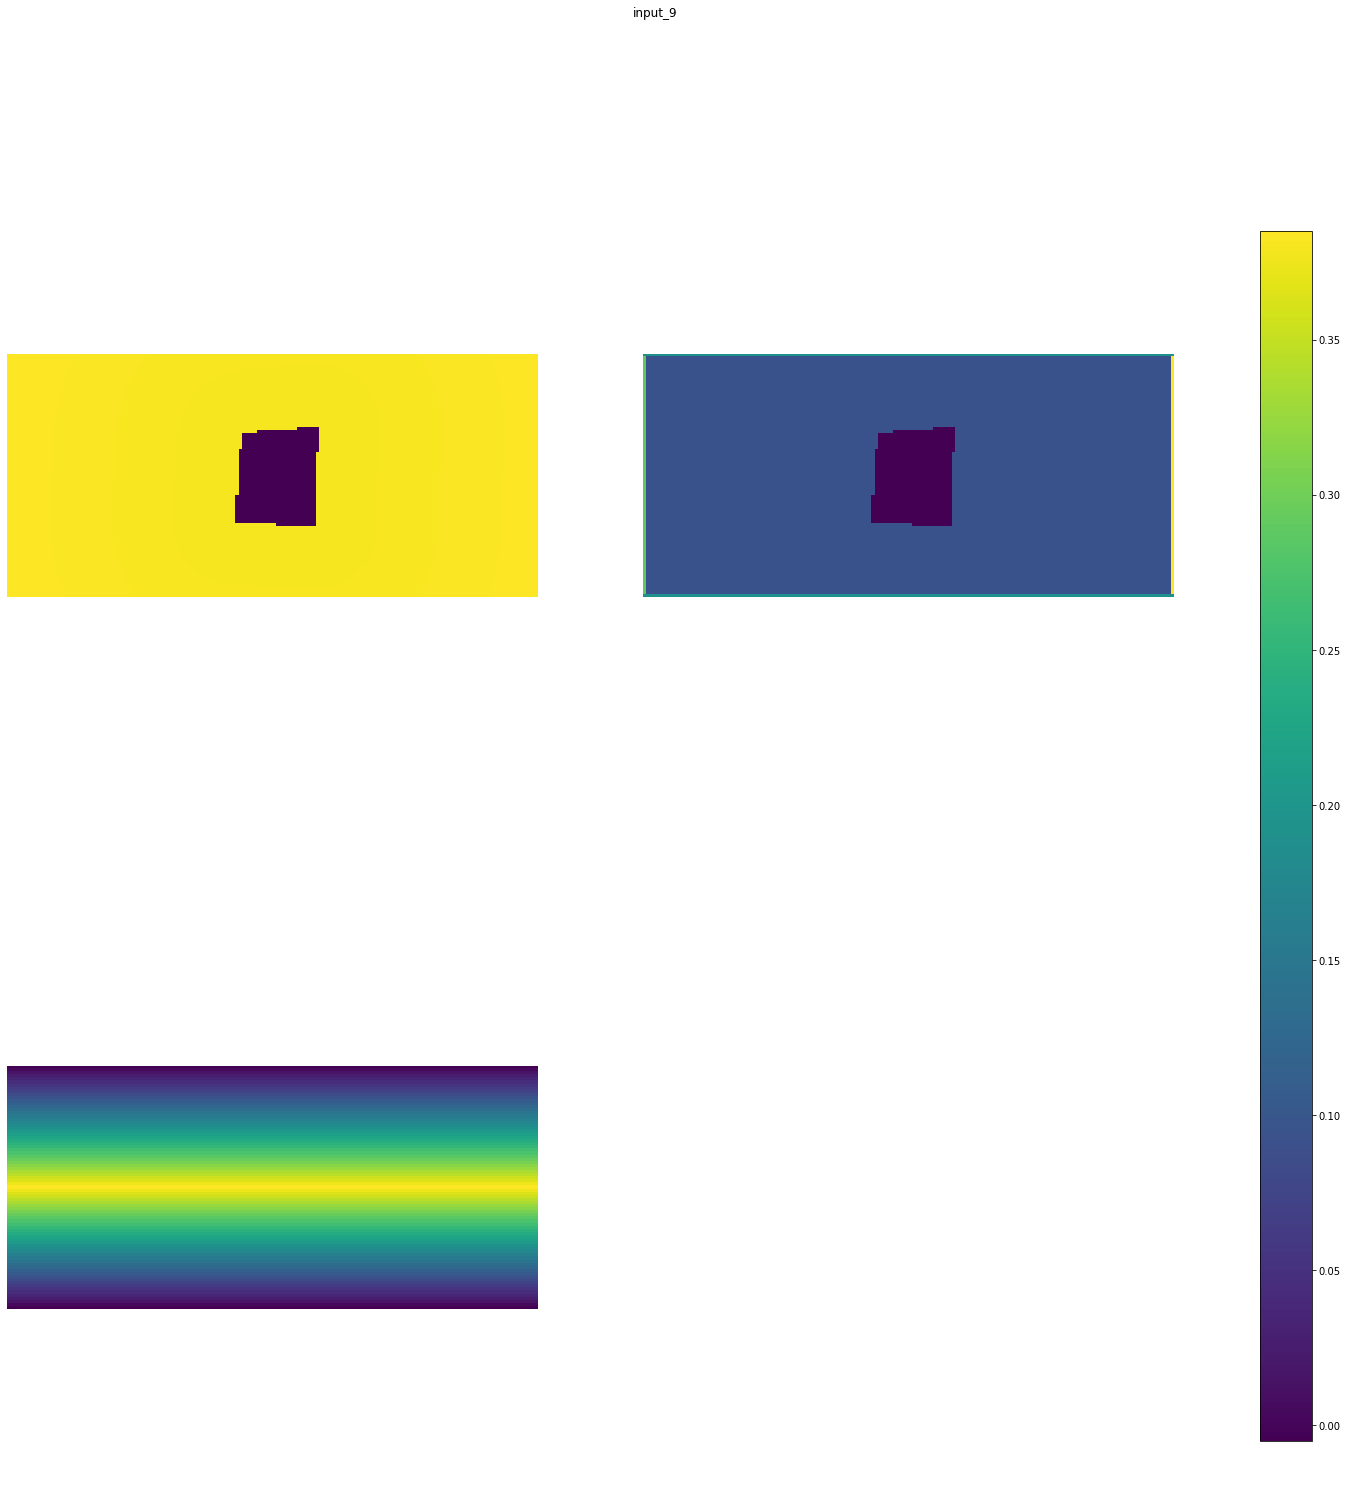

block1_layer1_conv2d (1, 79, 172, 8) 


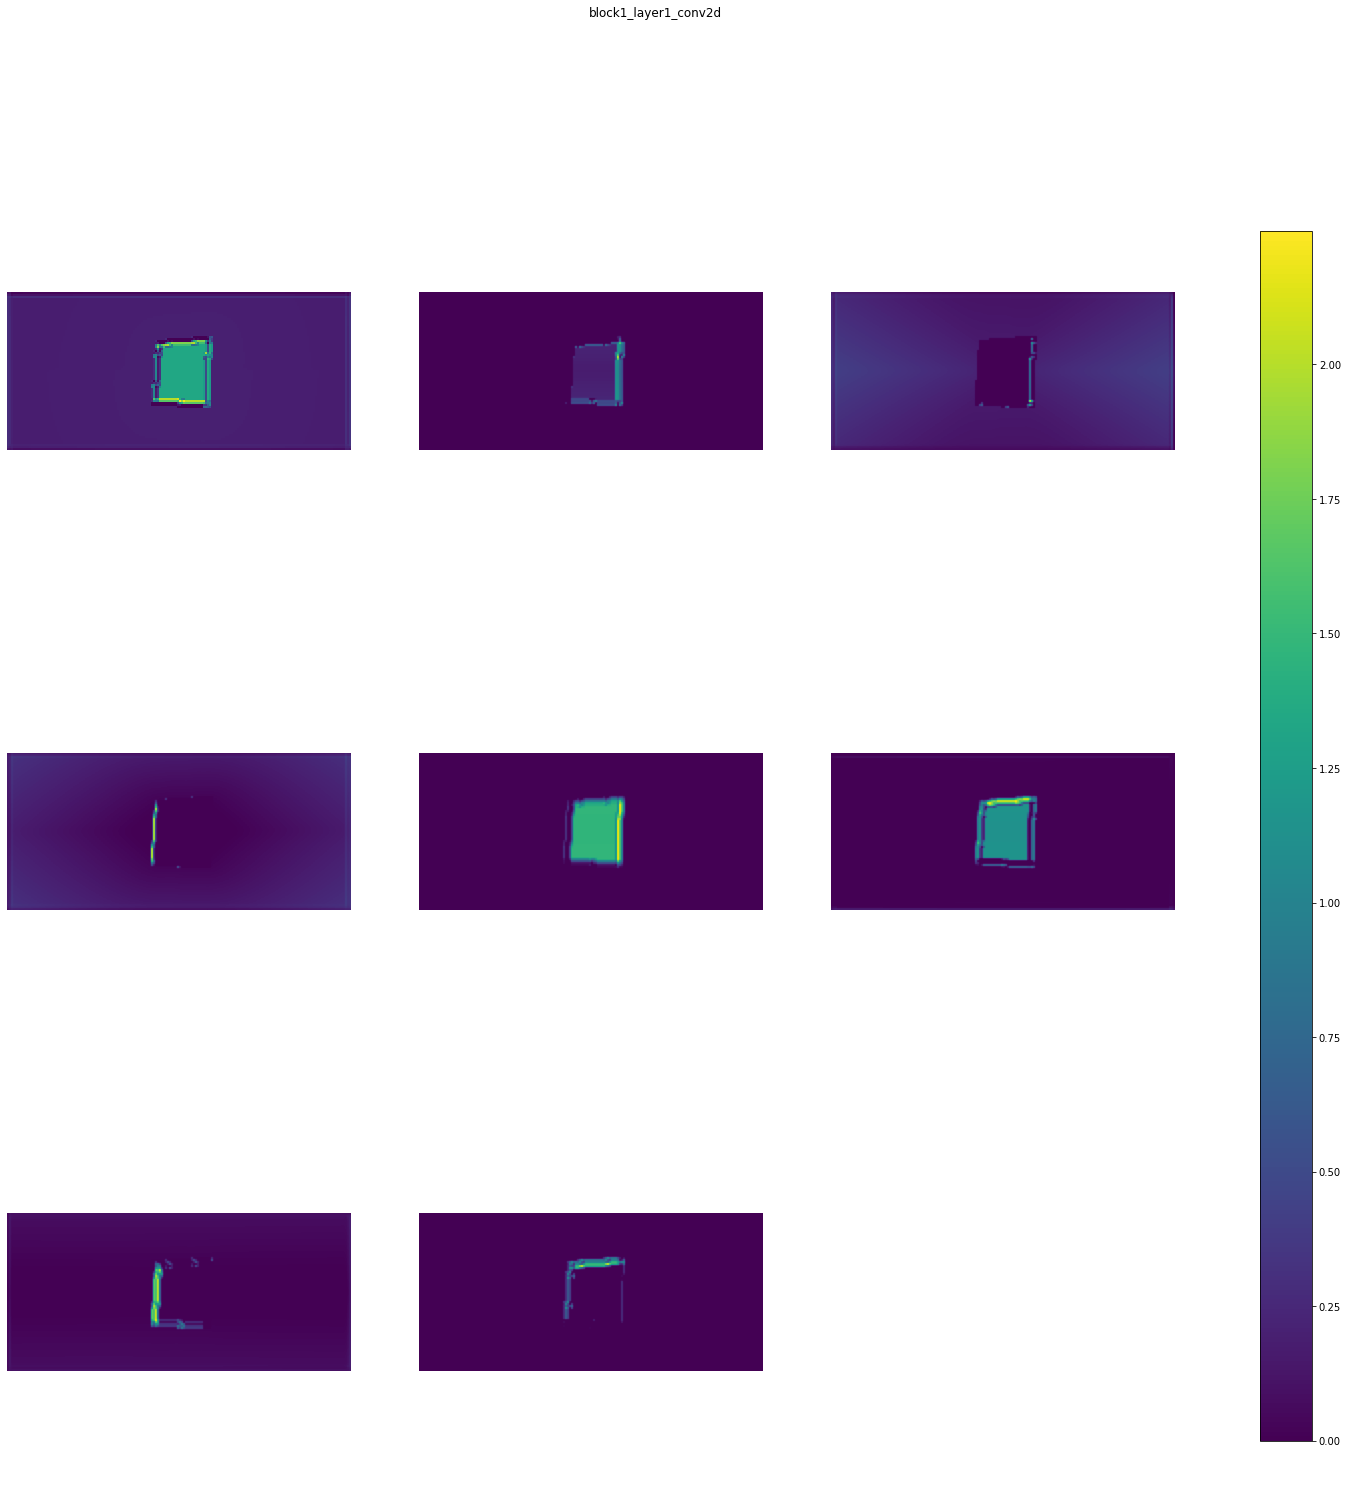

conv2d_57 (1, 79, 172, 8) 


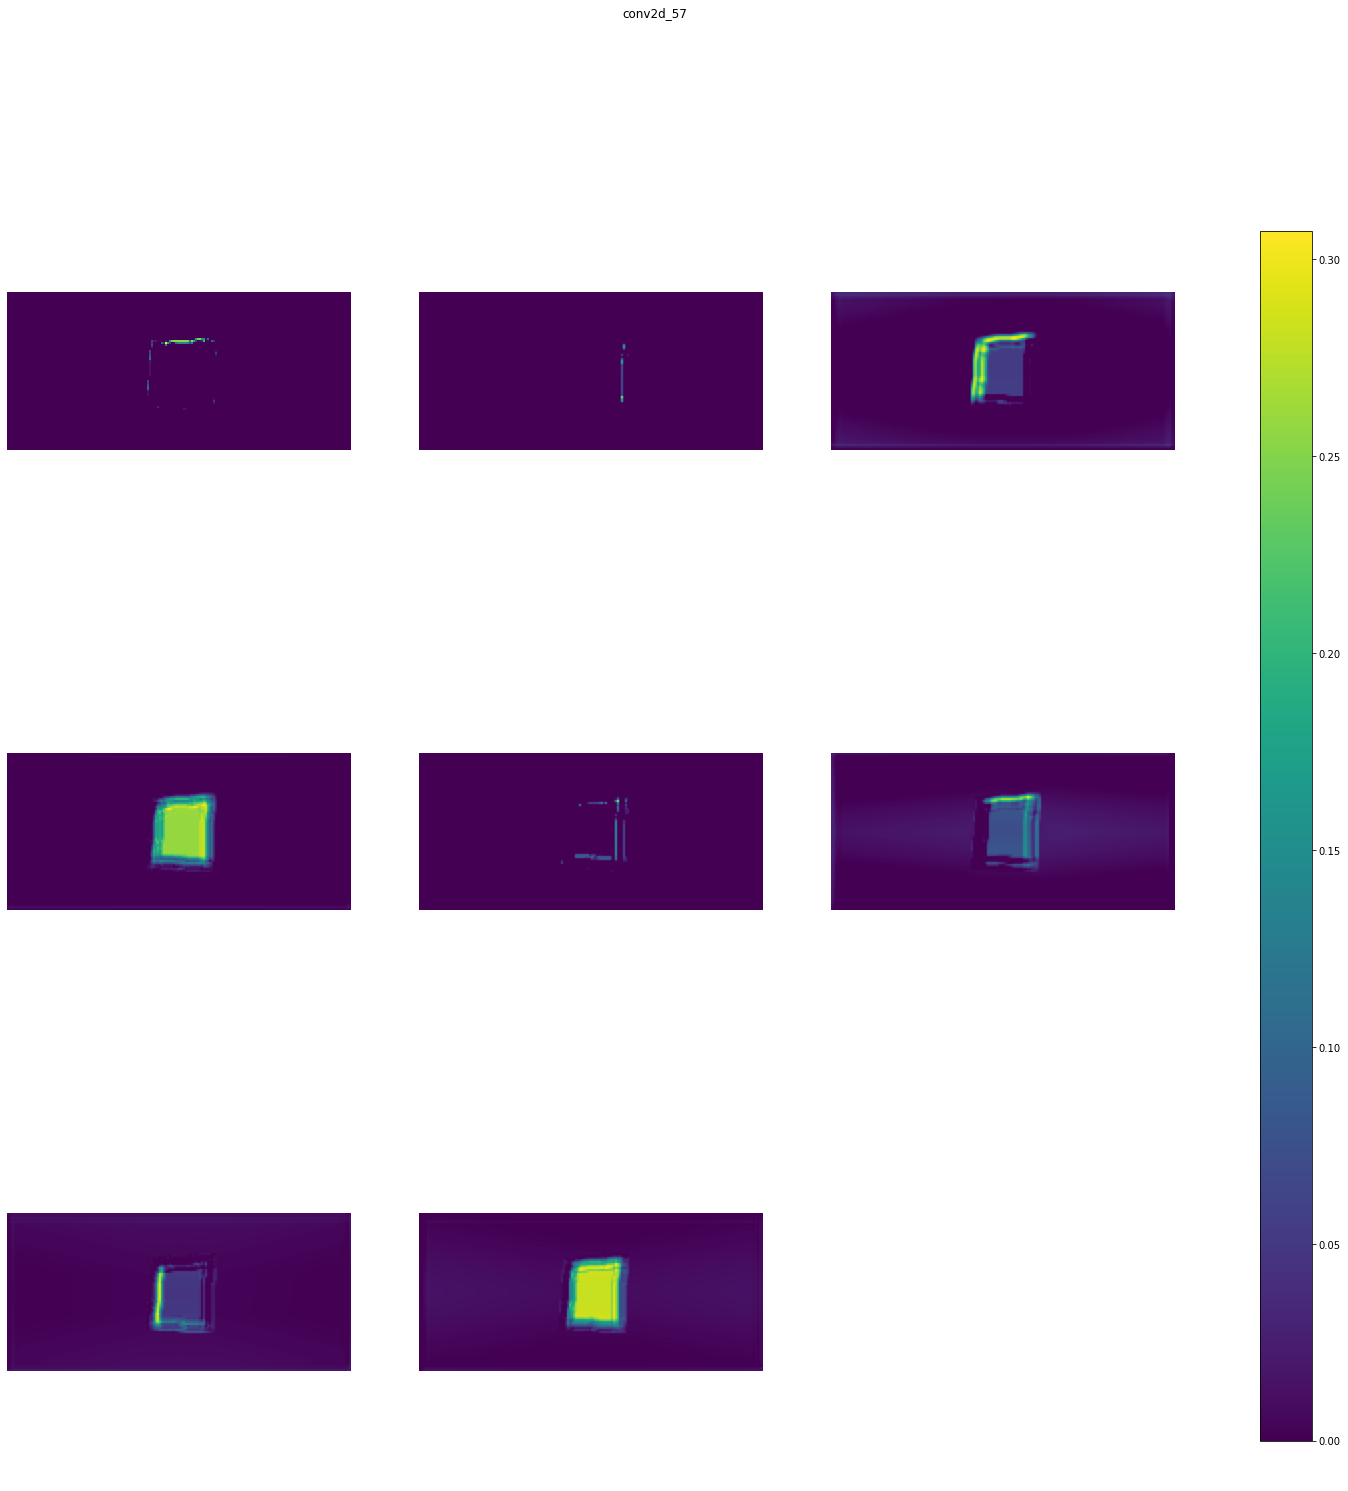

AttributeError: 'list' object has no attribute 'shape'

In [48]:
import keract
sample_x = x[:1,:,:,:]
activations = keract.get_activations(model, sample_x)
keract.display_activations(activations)

In [ ]:
import os
import pickle
import torch
from torchsummary import summary
from DeepCFD.Models.UNetEx import UNetEx

In [10]:
torch.cuda.empty_cache()
import gc
gc.collect()

filters = [8, 16, 32, 32]
kernel_size = 5
bn = False
wn = False

x_path = os.path.join(os.getcwd(), 'DeepCFD', 'dataX.pkl')
y_path = os.path.join(os.getcwd(), 'DeepCFD', 'dataY.pkl')
x = pickle.load(open(x_path, 'rb'))
y = pickle.load(open(y_path, 'rb'))

input_channels = x.shape[1]
input_height = x.shape[3]
input_width = x.shape[2]
print(x.shape)

model = UNetEx(3, 3, filters=filters, kernel_size=kernel_size, batch_norm=bn, weight_norm=wn)
if torch.cuda.is_available():
    model.cuda()
summary(model, input_size=(input_channels, input_height, input_width))

NameError: name 'torch' is not defined

In [11]:
import os
import json
import torch
import pickle
from DeepCFD.train_functions import *
from DeepCFD.functions import *
import torch.optim as optim
from torch.utils.data import TensorDataset
from DeepCFD.Models.UNetEx import UNetEx

# Loading dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_path = os.path.join(os.getcwd(), 'DeepCFD', 'dataX.pkl')
y_path = os.path.join(os.getcwd(), 'DeepCFD', 'dataY.pkl')
x = pickle.load(open(x_path, 'rb'))
y = pickle.load(open(y_path, 'rb'))
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)    
channels_weights = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).reshape((981*172*79,3)) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
print(channels_weights)

simulation_directory = "./Run/"
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)

# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)

train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)        
test_x, test_y = test_dataset[:]

torch.manual_seed(0)
lr = 0.001
kernel_size = 5
filters = [8, 16, 32, 32]
bn = False
wn = False
wd = 0.005
model = UNetEx(3, 3, filters=filters, kernel_size=kernel_size, batch_norm=bn, weight_norm=wn)
# Define opotimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd) 

config = {}        
train_loss_curve = []
test_loss_curve = []
train_mse_curve = []
test_mse_curve = []
train_ux_curve = []
test_ux_curve = []
train_uy_curve = []
test_uy_curve = []
train_p_curve = []
test_p_curve = []

def after_epoch(scope):
    train_loss_curve.append(scope["train_loss"])
    test_loss_curve.append(scope["val_loss"])
    train_mse_curve.append(scope["train_metrics"]["mse"])
    test_mse_curve.append(scope["val_metrics"]["mse"])
    train_ux_curve.append(scope["train_metrics"]["ux"])
    test_ux_curve.append(scope["val_metrics"]["ux"])
    train_uy_curve.append(scope["train_metrics"]["uy"])
    test_uy_curve.append(scope["val_metrics"]["uy"])
    train_p_curve.append(scope["train_metrics"]["p"])
    test_p_curve.append(scope["val_metrics"]["p"])

def loss_func(model, batch):
    x, y = batch
    output = model(x)
    lossu = ((output[:,0,:,:] - y[:,0,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    lossv = ((output[:,1,:,:] - y[:,1,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    lossp = torch.abs((output[:,2,:,:] - y[:,2,:,:])).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    loss = (lossu + lossv + lossp)/channels_weights
    return torch.sum(loss), output

# Training model
DeepCFD, train_metrics, train_loss, test_metrics, test_loss = train_model(model, loss_func, train_dataset, test_dataset, optimizer,
    epochs=10, batch_size=64, device=device,
    m_mse_name="Total MSE",
    m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
    m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
    m_ux_name="Ux MSE",
    m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
    m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
    m_uy_name="Uy MSE",
    m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
    m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
    m_p_name="p MSE",
    m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
    m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]), patience=25, after_epoch=after_epoch
    )

metrics = {}
metrics["train_metrics"] = train_metrics
metrics["train_loss"] = train_loss
metrics["test_metrics"] = test_metrics
metrics["test_loss"] = test_loss
curves = {}
curves["train_loss_curve"] = train_loss_curve
curves["test_loss_curve"] = test_loss_curve
curves["train_mse_curve"] = train_mse_curve
curves["test_mse_curve"] = test_mse_curve
curves["train_ux_curve"] = train_ux_curve
curves["test_ux_curve"] = test_ux_curve
curves["train_uy_curve"] = train_uy_curve
curves["test_uy_curve"] = test_uy_curve
curves["train_p_curve"] = train_p_curve
curves["test_p_curve"] = test_p_curve
config["metrics"] = metrics
config["curves"] = curves
with open(simulation_directory + "results.json", "w") as file:
    json.dump(config, file)

out = DeepCFD(test_x[:10].to(device))
error = torch.abs(out.cpu() - test_y[:10].cpu())
s = 0

tensor([[[[0.1153]],

         [[0.0175]],

         [[0.0135]]]], device='cuda:0')
Epoch #1
	Train Loss = 356031580.5
	Train Total MSE = 3264.5317169278424
	Train Ux MSE = 468.56191776375726
	Train Uy MSE = 1693.0059632949162
	Train p MSE = 1102.9638792877643
	Validation Loss = 43172628.0
	Validation Total MSE = 597.1358845338983
	Validation Ux MSE = 179.56986559851694
	Validation Uy MSE = 282.42829713983053
	Validation p MSE = 135.1377251059322
Model saved!
Epoch #2
	Train Loss = 76628936.0
	Train Total MSE = 452.53312340561223
	Train Ux MSE = 127.47980679436954
	Train Uy MSE = 258.604015294734
	Train p MSE = 66.44929277514578
	Validation Loss = 27050654.0
	Validation Total MSE = 355.88168034957624
	Validation Ux MSE = 86.89113645391949
	Validation Uy MSE = 234.4308527542373
	Validation p MSE = 34.559696520789196
Model saved!
Epoch #3
	Train Loss = 58292077.0
	Train Total MSE = 321.64952794733966
	Train Ux MSE = 72.35156107643951
	Train Uy MSE = 218.94895112062682
	Train p MSE = 30.3

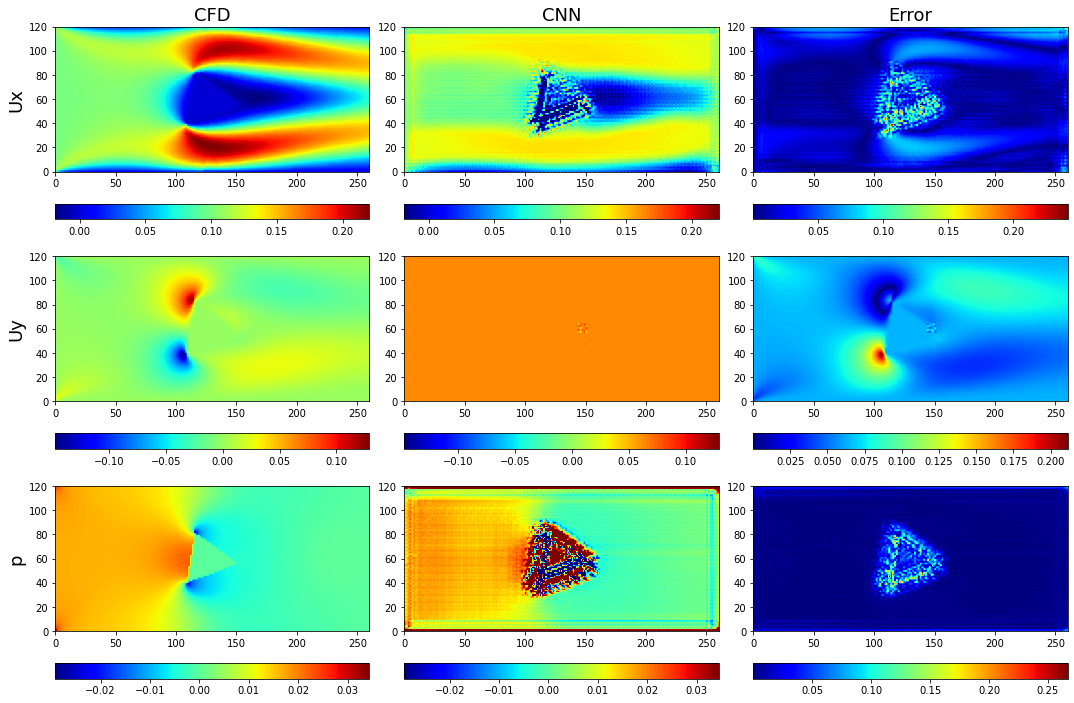

In [12]:
visualize(test_y[:10].cpu().detach().numpy(), out[:10].cpu().detach().numpy(), error[:10].cpu().detach().numpy(), s)

In [64]:
encoder_decoder = list(DeepCFD.children())

sample_x = test_x[:1].cpu().detach().numpy()
sample_x = torch.from_numpy(sample_x).cuda()

results = []
# encoder visualistion
for block in encoder_decoder[0].children():
    for layer in block.children():
        for operation in layer.children():
            if type(operation) == torch.nn.Conv2d:
                sample_x = operation(sample_x)
            results.append(sample_x)
            print(operation)

outputs = results

Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU()
Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU()
Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU()
Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU()
Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU()
Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU()
Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU()
Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU()


In [109]:
import torch.nn.functional as F


x = pickle.load(open(x_path, 'rb'))
x = torch.FloatTensor(x)
y = pickle.load(open(y_path, 'rb'))
y = torch.FloatTensor(y)
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x[:2,:,:,:], y[:2,:,:,:], ratio=0.5)

train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)        
test_x, test_y = test_dataset[:]

conv1a = torch.nn.Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(test_x)
conv1b = torch.nn.Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(conv1a)
pool1, ind1 = F.max_pool2d(conv1a, 2, 2, return_indices=True)

conv2a = torch.nn.Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(pool1)
conv2b = torch.nn.Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(conv2a)
pool2, ind2 = F.max_pool2d(conv2a, 2, 2, return_indices=True)

conv3a = torch.nn.Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(pool2)
conv3b = torch.nn.Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(conv3a)
pool3, ind3 = F.max_pool2d(conv3a, 2, 2, return_indices=True)

conv4a = torch.nn.Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(pool3)
conv4b = torch.nn.Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(conv4a)
pool4, ind4 = F.max_pool2d(conv4a, 2, 2, return_indices=True)

conv5a = torch.nn.Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(pool4)
conv5b = torch.nn.Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(conv5a)
pool5, ind5 = F.max_pool2d(conv5a, 2, 2, return_indices=True)

unpool5 = F.max_unpool2d(pool5, ind5, 2, 2, output_size=conv5b.size())
cat5 = torch.cat([conv5b, unpool5], dim=1)
deconv5a = torch.nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(cat5)
deconv5b = torch.nn.ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(deconv5a)

unpool4 = F.max_unpool2d(pool4, ind4, 2, 2, output_size=conv4b.size())
cat4 = torch.cat([conv4b, unpool4], dim=1)
deconv4a = torch.nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(cat4)
deconv4b = torch.nn.ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(deconv4a)

unpool3 = F.max_unpool2d(pool3, ind3, 2, 2, output_size=conv3b.size())
cat3 = torch.cat([conv3b, unpool3], dim=1)
deconv3a = torch.nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(cat3)
deconv3b = torch.nn.ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(deconv3a)

unpool2 = F.max_unpool2d(pool2, ind2, 2, 2, output_size=conv2b.size())
cat2 = torch.cat([conv2b, unpool2], dim=1)
deconv2a = torch.nn.ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(cat2)
deconv2b = torch.nn.ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(deconv2a)

unpool1 = F.max_unpool2d(pool1, ind1, 2, 2, output_size=conv1b.size())
cat1 = torch.cat([conv1b, unpool1], dim=1)
deconv1a = torch.nn.ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(cat1)
deconv1b = torch.nn.ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(deconv1a)

In [116]:
i = 1
print(pool4[0,i,:,:])
print(unpool4[0,i,:,:])

tensor([[ 3.9001e-03, -1.5597e-02, -2.7892e-04,  3.3188e-02],
        [-7.6967e-02, -9.9045e-02, -8.4140e-02, -1.1179e-02],
        [-9.5649e-02, -1.1110e-01, -9.5496e-02, -1.9799e-02],
        [ 4.2593e-02,  6.5872e-01,  1.4701e+00,  3.1235e-01],
        [ 1.2321e-02,  2.0473e+00,  3.0150e+00,  1.5073e+00],
        [ 6.8134e-01,  2.0169e+00,  2.6529e+00,  1.8566e+00],
        [ 3.5905e-01,  1.4119e+00,  1.5780e+00,  8.3699e-01],
        [ 1.6920e-01,  1.8144e-01,  1.5695e-01, -2.8520e-02],
        [-9.8460e-02, -1.1450e-01, -9.7374e-02, -2.2782e-02],
        [-8.7362e-02, -1.2572e-01, -1.1248e-01, -3.4248e-02]],
       grad_fn=<SliceBackward>)
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.9001e-03,  0.0000e+00,  0.0000e+00, -1.5597e-02,  0.0000e+00,
         -2.7892e-04,  0.0000e+00,  3.3188e-02,  0.0000e+00],
        [-7.6967e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
 

torch.Size([8, 172, 79])
torch.Size([8, 172, 79])
torch.Size([8, 172, 79])
torch.Size([8, 172, 79])
torch.Size([16, 172, 79])
torch.Size([16, 172, 79])
torch.Size([16, 172, 79])
torch.Size([16, 172, 79])
torch.Size([32, 172, 79])
torch.Size([32, 172, 79])
torch.Size([32, 172, 79])
torch.Size([32, 172, 79])
torch.Size([32, 172, 79])
torch.Size([32, 172, 79])
torch.Size([32, 172, 79])
torch.Size([32, 172, 79])


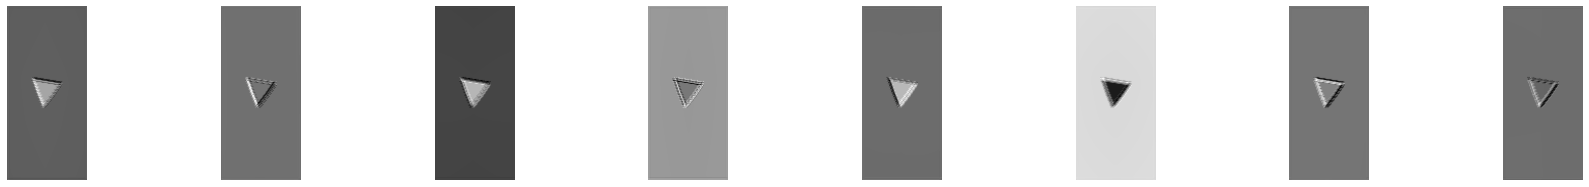

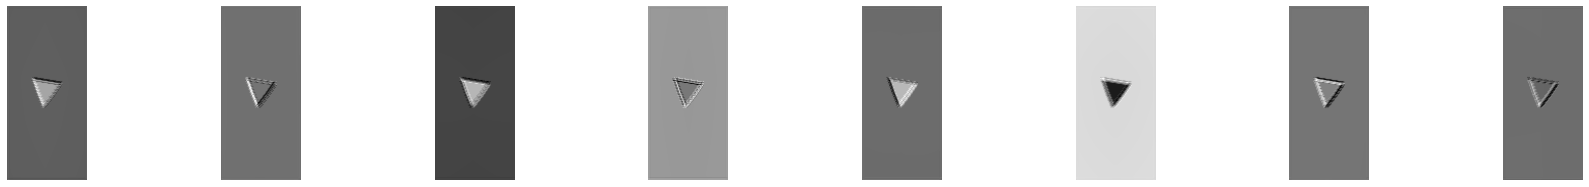

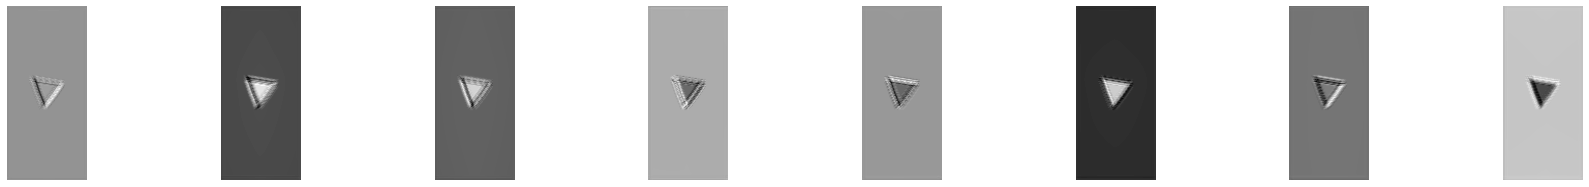

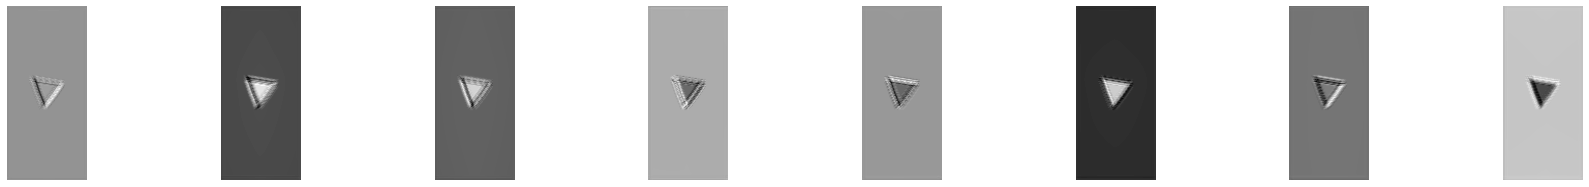

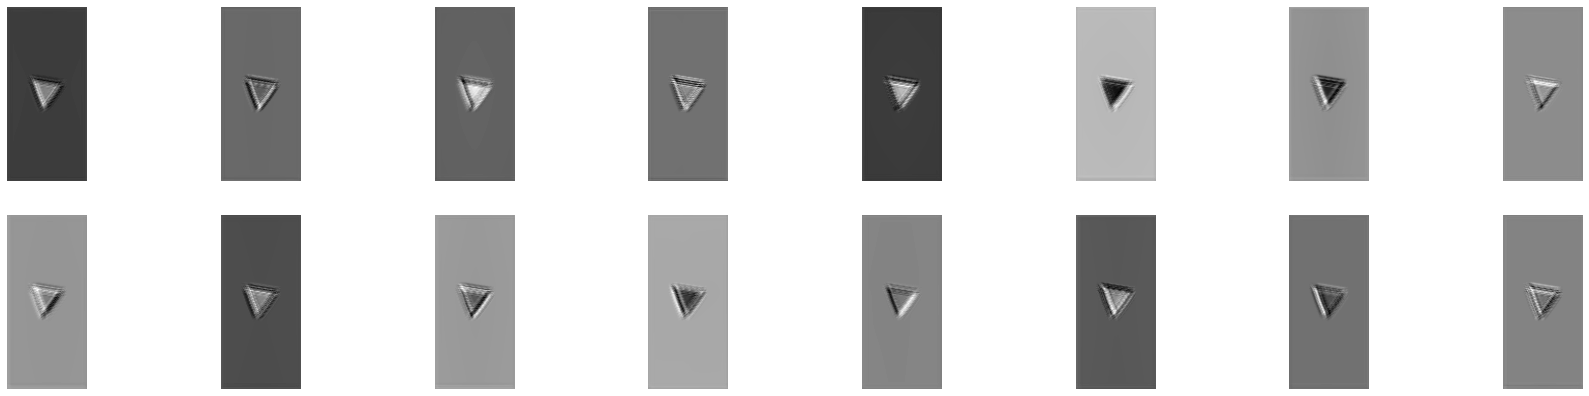

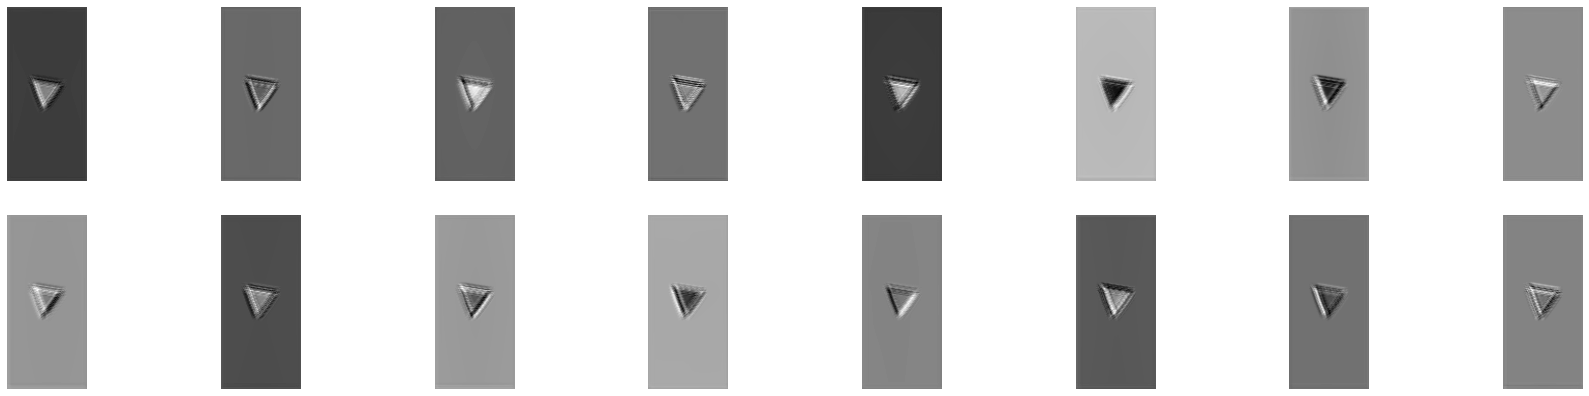

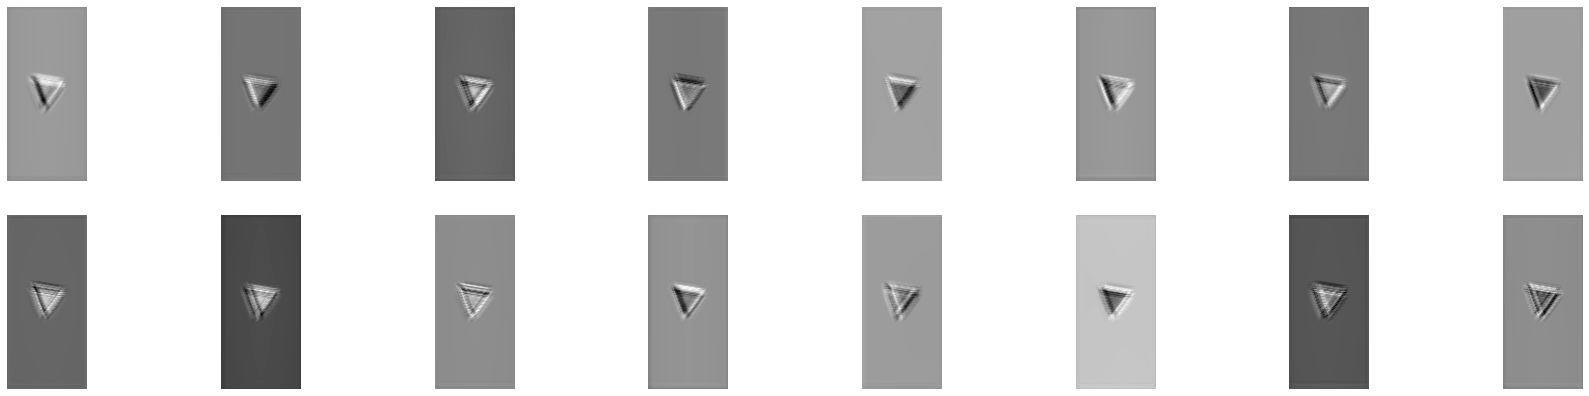

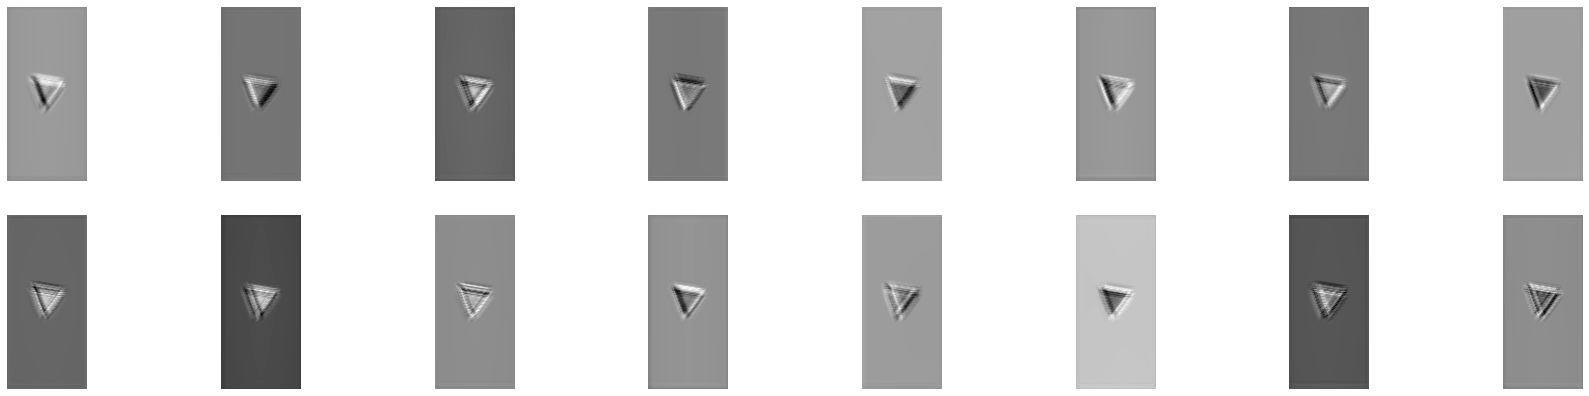

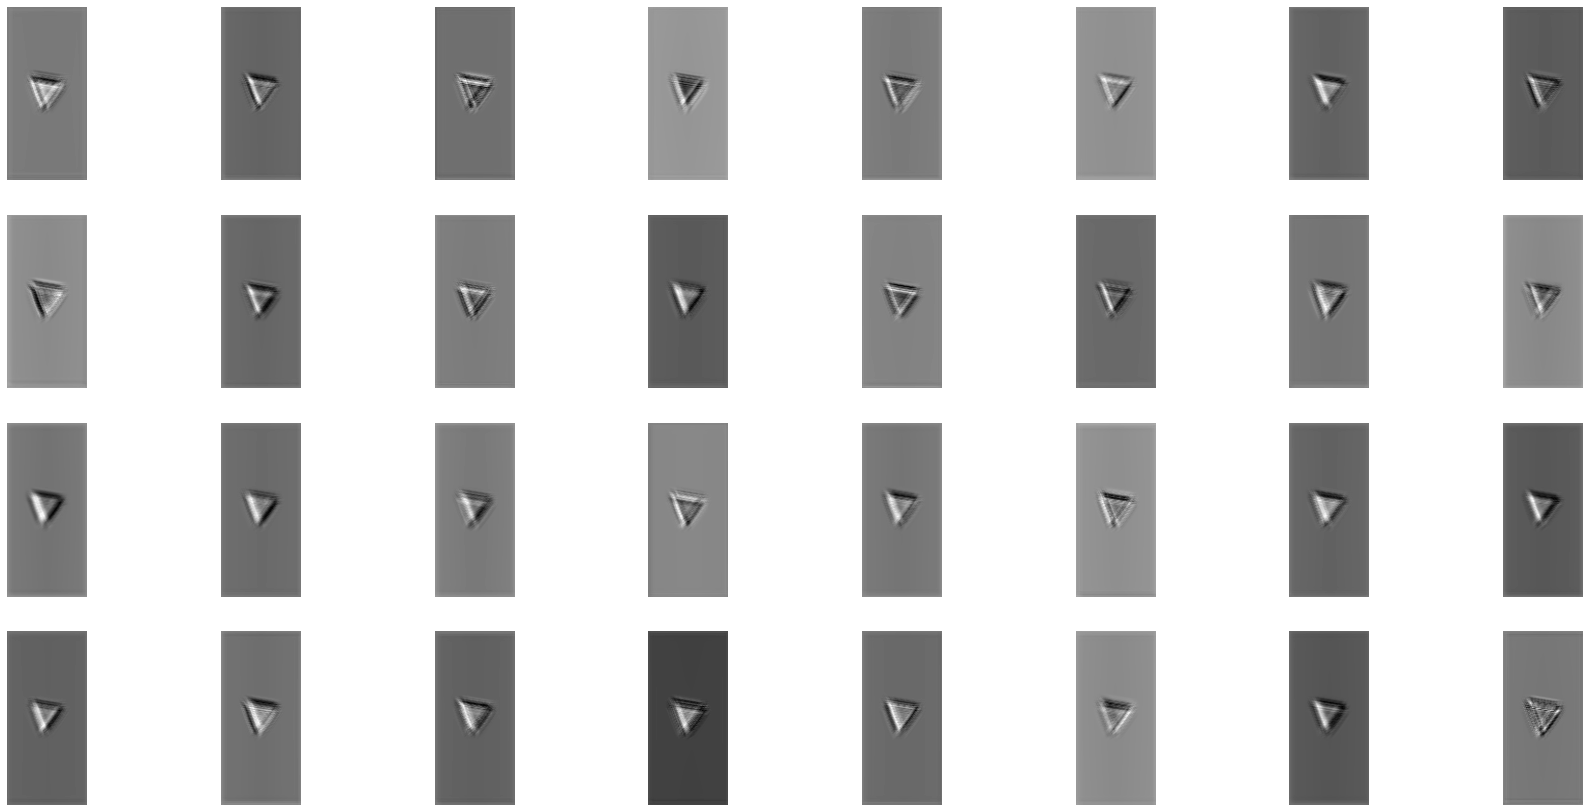

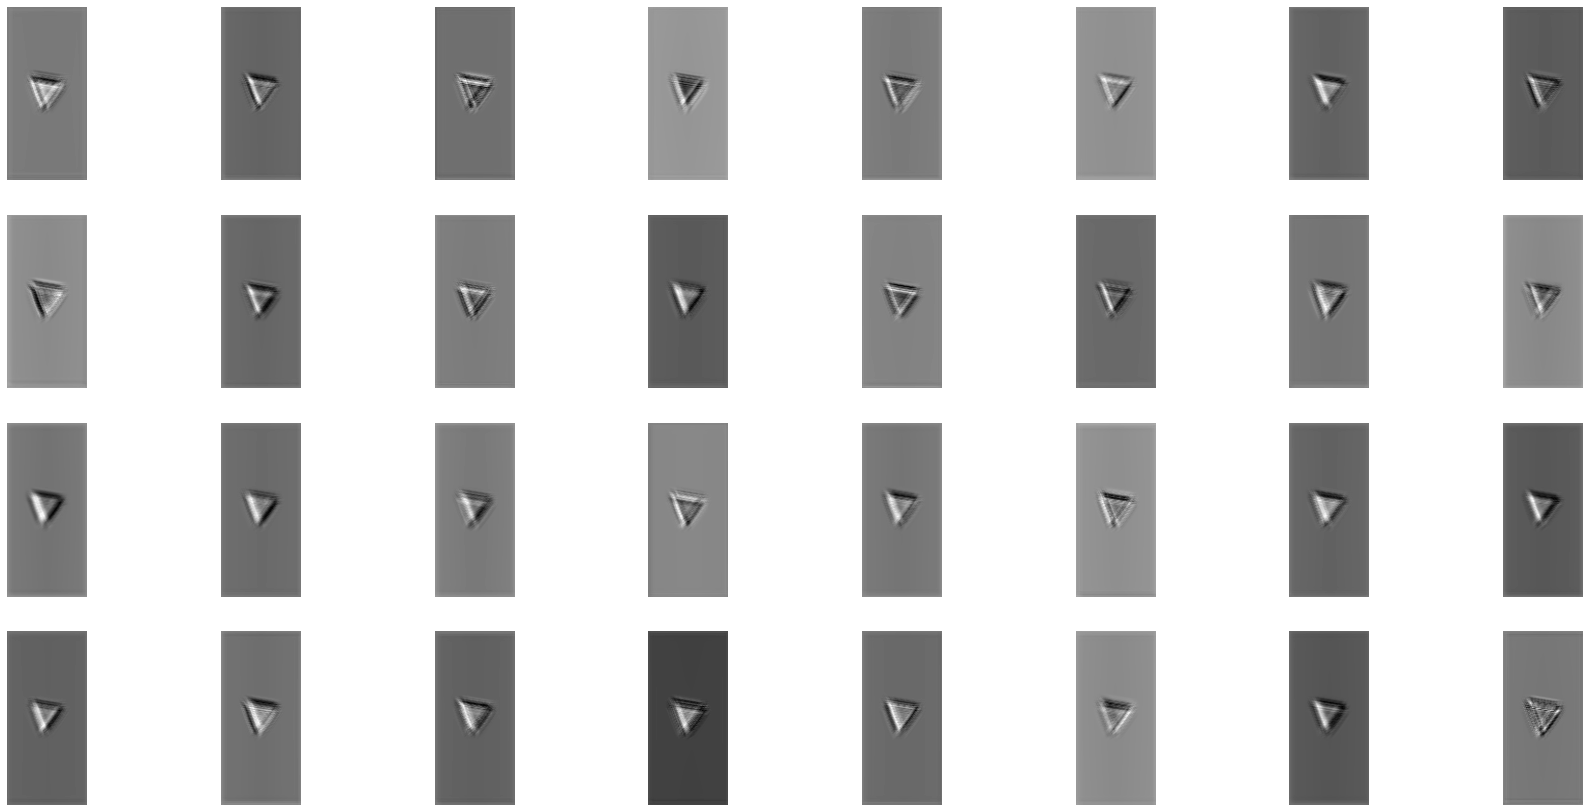

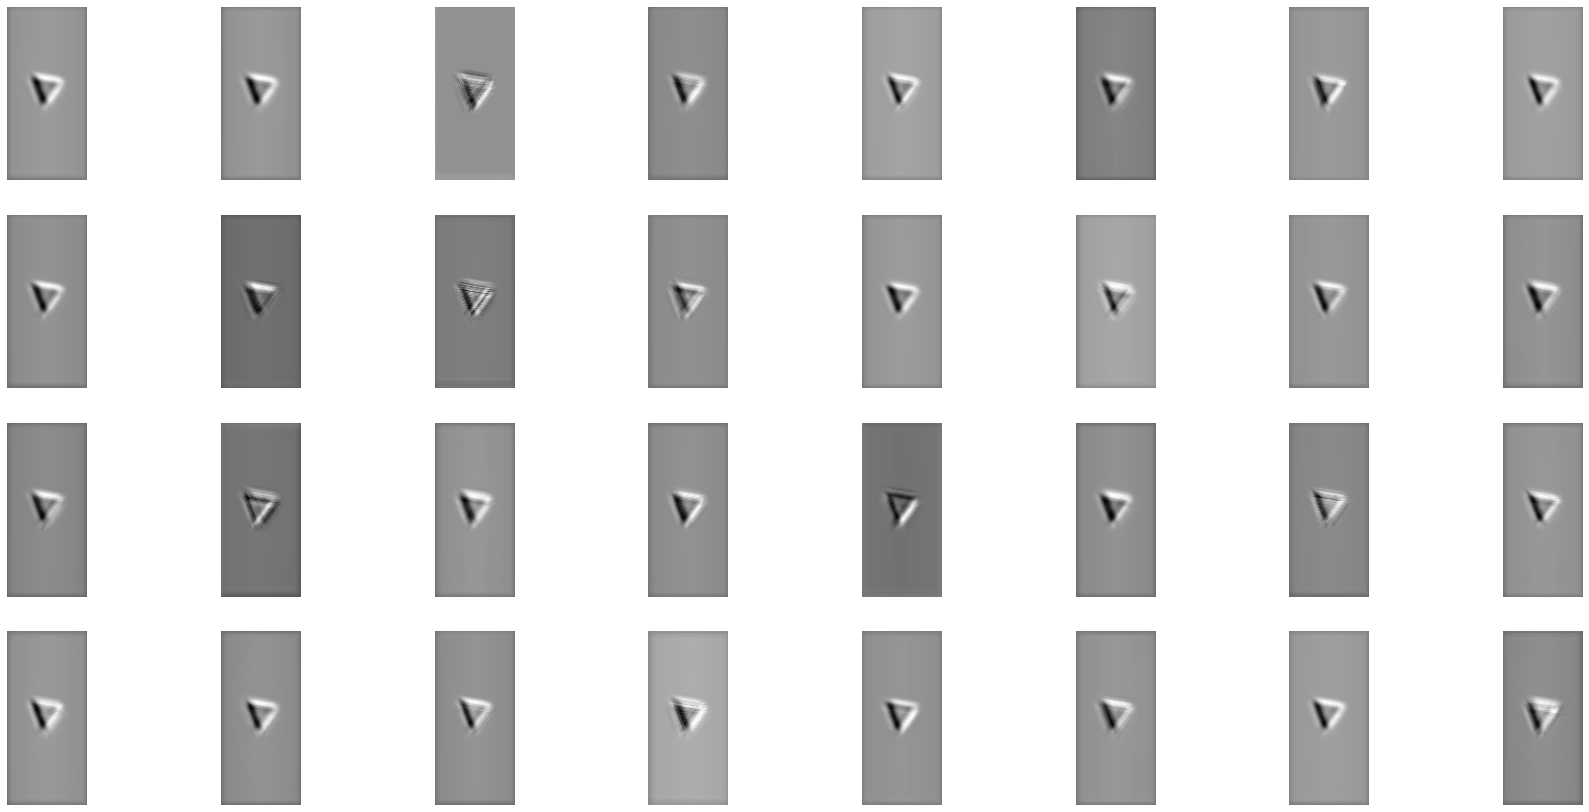

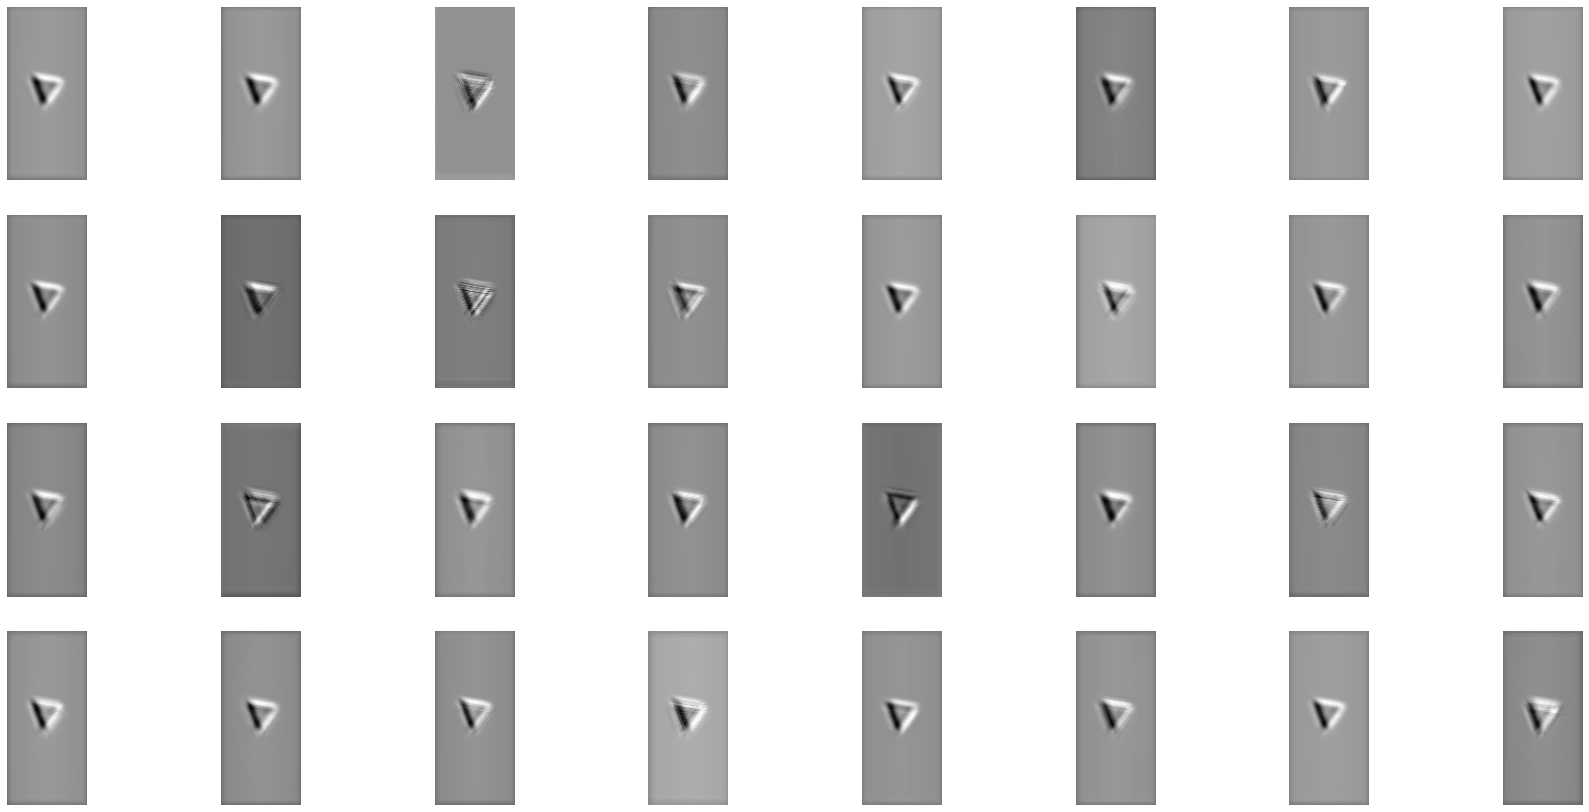

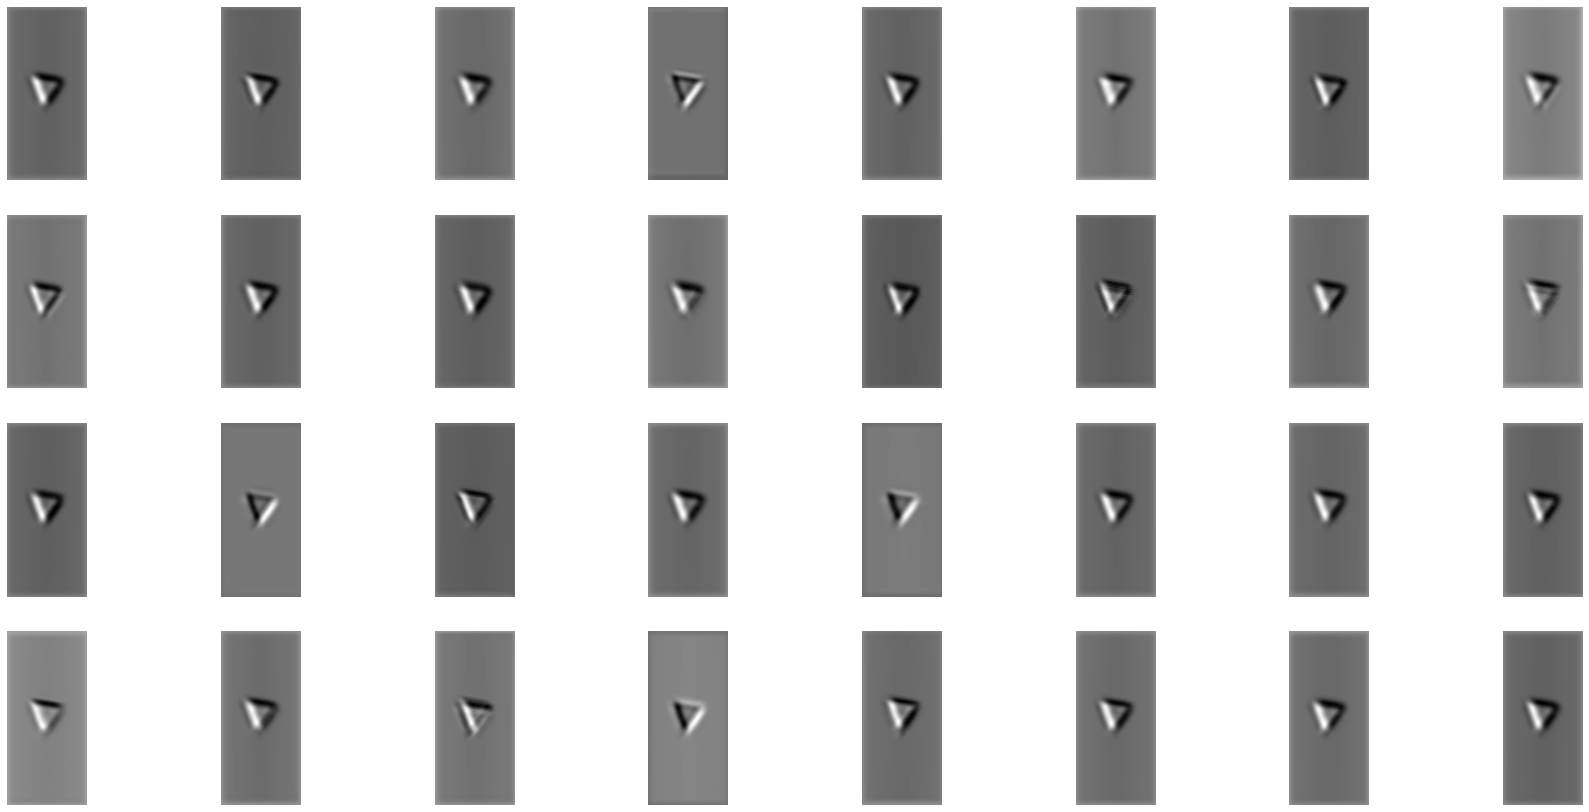

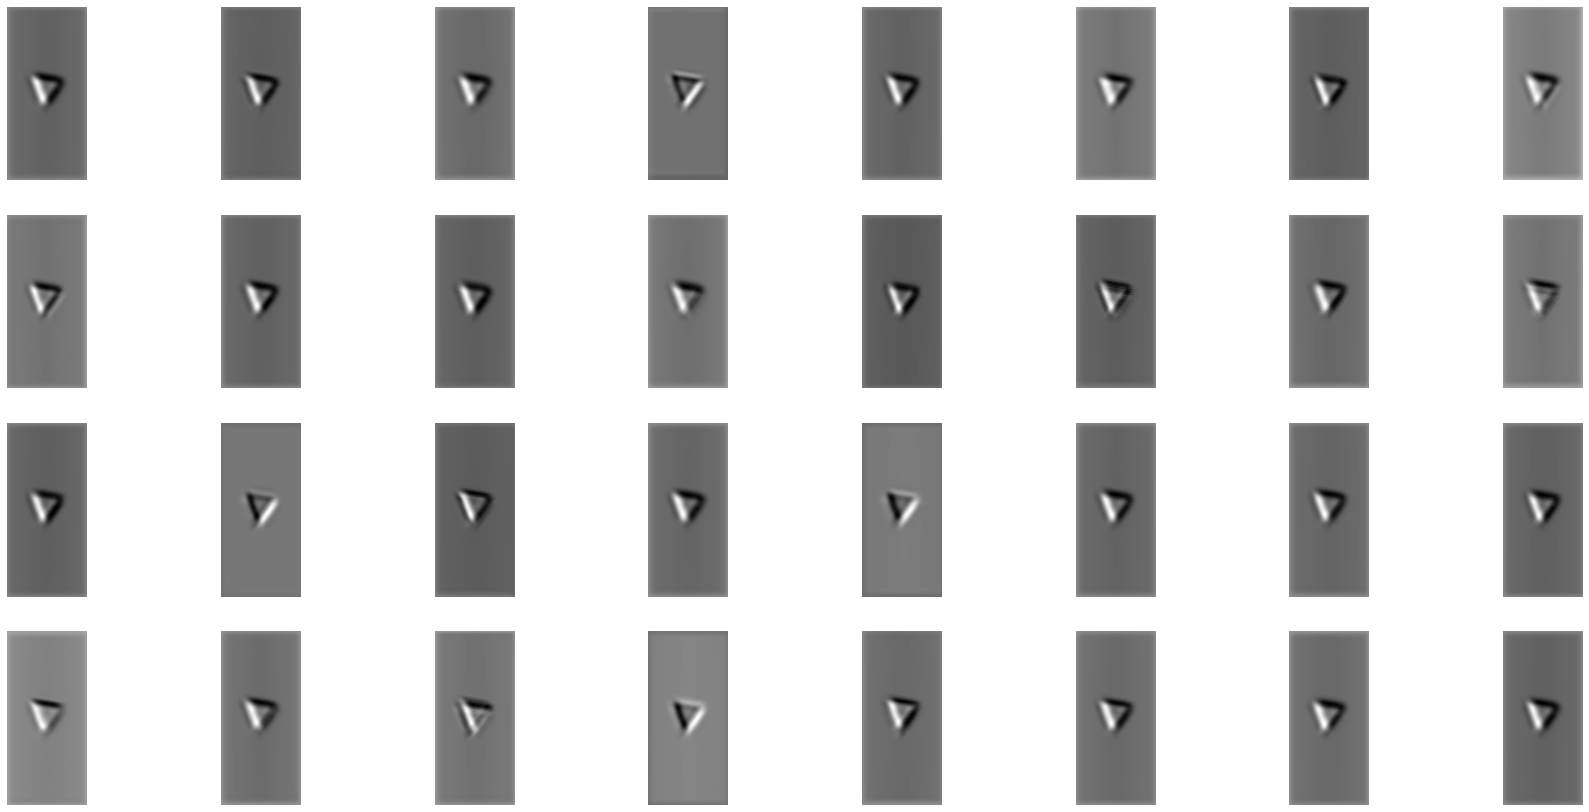

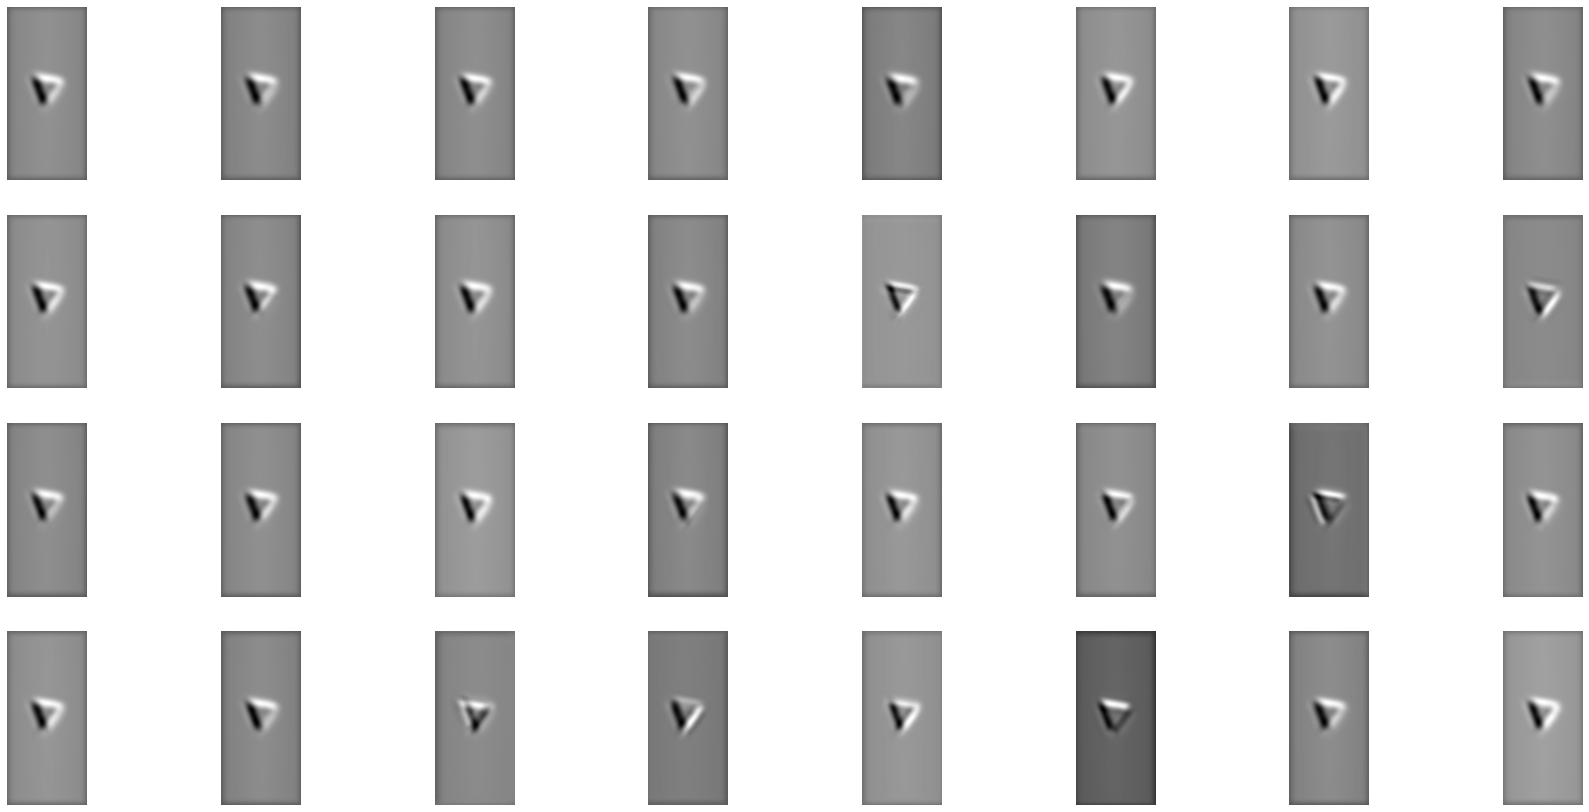

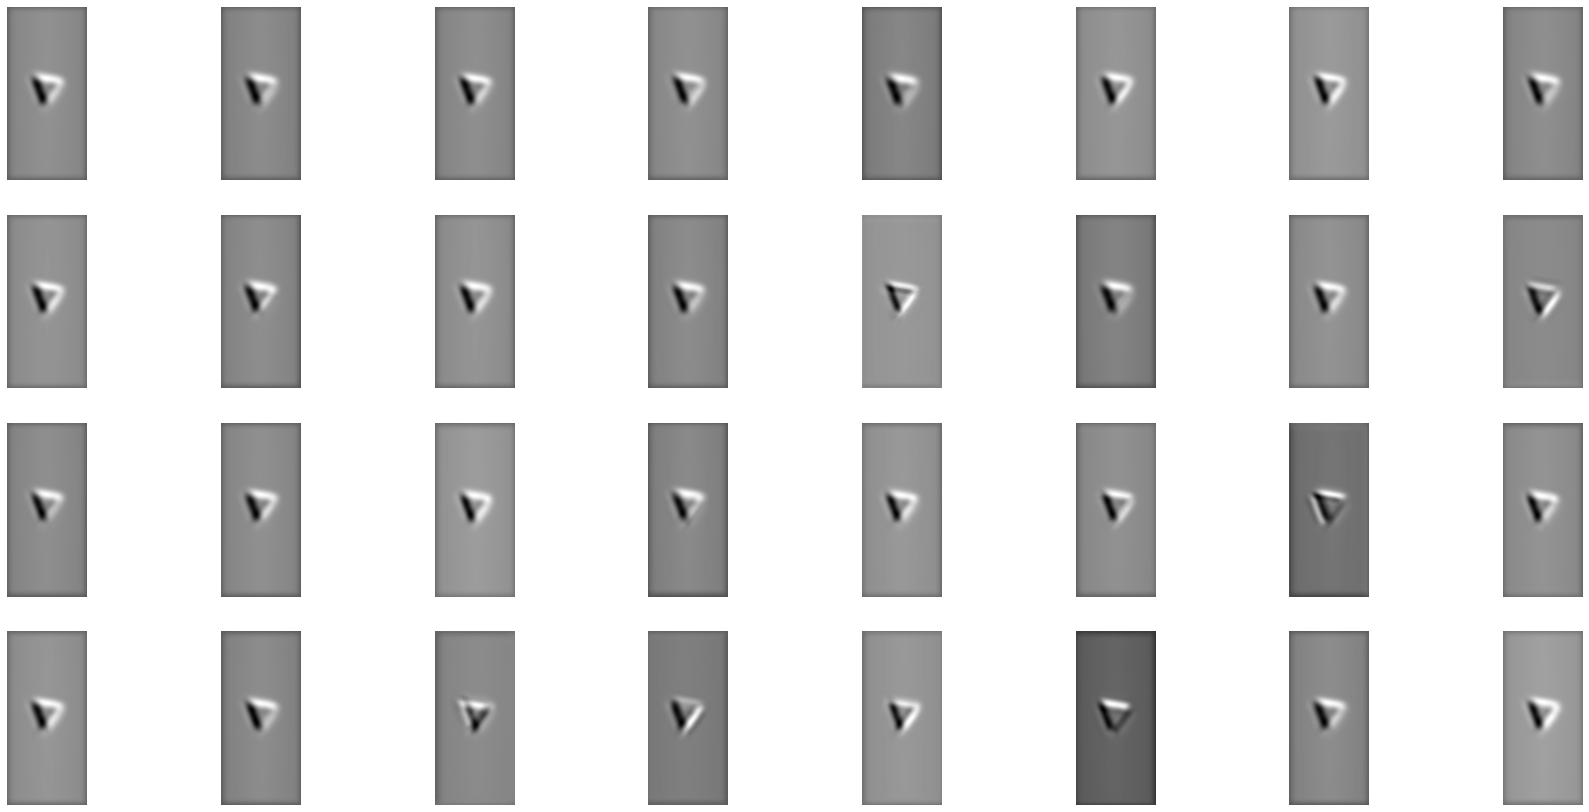

In [61]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    layer_viz = layer_viz.cpu().detach().numpy()
    for i, f in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(f, cmap='gray')
        plt.axis("off")
#     print(f"Saving layer {num_layer} feature maps...")
#     print(result)

In [63]:
layer_viz.shape

(32, 172, 79)

In [74]:
%load_ext tensorboard
# %tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
